In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import datetime as dt

## Load input data

In [231]:
vot_pdf = np.genfromtxt('VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
vot_p=vot_p/np.sum(vot_p)

## Travel time functions

In [27]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

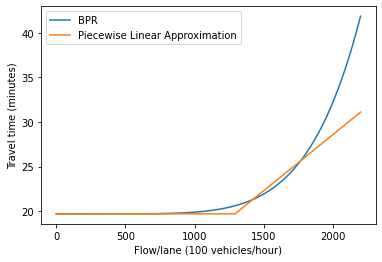

In [28]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

## Generate demand profile

In [229]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau: {}'.format(tau_arr))

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B: {}'.format(B_arr))

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range: {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print('Ineligible vot range: {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print('Mean vot: {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
B: [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]
Eligible vot range: 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)
Ineligible vot range: 0.21(12.6 $/hr), 2.7 (162.0 $/hr)
Mean vot: 44.4 $/hr; median: 37.2 $/hr


Text(0, 0.5, '% of population')

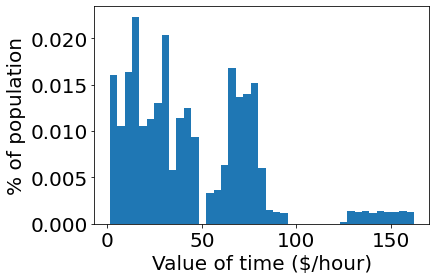

In [230]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

## Define Social Objectives of Interest

In [38]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.65
17.93
23.28
30.06
37.0
43.96
63.59
68.8
74.75
80.18
162.23


In [94]:
demand_multiplier = [25,75]

###### Evaluate Travel Time Metrics ###### 
def evaluate_avg_tt_in(solution_, demand_multiplier):
    """
    Average travel time ineligible only
    """
    ineligible_tt = sum(solution_['users_in'][k, i, j]*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                                    capacity = bpr_true_capacity*demand_multiplier[i],
                                                                    b = apx_slope/demand_multiplier[i])
                                 for k in range(num_ineligible) for i in range(2) for j in range(T))/(T*num_ineligible)
    return ineligible_tt

def evaluate_avg_tt_el(solution_, demand_multiplier):
    """
    Average travel time eligible only
    """
    eligible_tt = sum((solution_['users_el'][ i, j]/num_eligible)*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                               capacity = bpr_true_capacity*demand_multiplier[i],
                                                               b = apx_slope/demand_multiplier[i])
                                for i in range(2) for j in range(T) )/(T*num_eligible)
    return eligible_tt

def evaluate_total_tt(solution_,demand_multiplier):
    """
    Total travel time  
    """
    ineligible_tt = evaluate_avg_tt_in(solution_, demand_multiplier)*num_ineligible*T
    eligible_tt = evaluate_avg_tt_el(solution_, demand_multiplier)*num_eligible*T
    
    return eligible_tt + ineligible_tt

def evaluate_avg_travel_time(solution_,demand_multiplier):
    """
    Average travel time  
    """
    return evaluate_total_tt(solution_,demand_multiplier)/(T*num_total)

def evaluate_avg_express_tt(solution_,demand_multiplier):
    """
    Average travel time on express lane
    """
    avg_EL_tt = sum(apx_bpr_cost(solution_['edge_flows'][0, j],capacity = bpr_true_capacity*demand_multiplier[0],
                                 b = apx_slope/demand_multiplier[0]) for j in range(T))/T
    return avg_EL_tt

def evaluate_avg_general_tt(solution_,demand_multiplier):
    """
    Average travel time on general purpose lanes
    """
    avg_GP_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, j],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) for j in range(T))/T
    return avg_GP_tt
    
def evaluate_avg_tt_savings(solution_,demand_multiplier):
    """
    Average travel time savings   
    """
    delta_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, j],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) - 
                   apx_bpr_cost(solution_['edge_flows'][0, j],capacity = bpr_true_capacity*demand_multiplier[0],
                                b = apx_slope/demand_multiplier[0])  for j in range(T))/T
    return delta_tt

###### Evaluate Lane Usage Metrics ###### 
def evaulate_express_usage(solution_,demand_multiplier):
    """
    Average share of all/el/inel users using express lane
    """
    share_eligible = sum(solution_['users_el'][ 0, j] for j in range(T))/(T*num_eligible)
    share_ineligible = sum(solution_['users_in'][k, 0, j] for k in range(num_ineligible) for j in range(T))/(T*num_ineligible)
    share_all = (sum(solution_['users_el'][ 0, j] for j in range(T))+
               sum(solution_['users_in'][k, 0, j] for k in range(num_ineligible) for j in range(T)))/(T*(num_total))
    return share_all, share_eligible, share_ineligible

def evaluate_express_usage_percentile_inel(solution_,demand_multiplier,percentiles):
    share_ineligible={}
    for p,thresh in percentiles.items():
        # number of ineligible users in the group
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0]) for j in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60)))[0]) for j in range(T))
        
        share_ineligible[p]=0
        for j in range(T):
            if p>=10:
                share_ineligible[p]+=sum(solution_['users_in'][k, 0, j] 
                                         for k in np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                           (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0])
            else:
                share_ineligible[p]+=sum(solution_['users_in'][k, 0, j] 
                                         for k in np.where((vot_ineligible[:,j]<=(thresh/60)))[0])
        if these_ineligible>0:
            share_ineligible[p]=share_ineligible[p]/these_ineligible
    return share_ineligible

###### Evaluate Travel Cost Metrics ###### 
def evaluate_total_travel_cost_in(solution_, tau, demand_multiplier):
    """
    Total travel cost for ineligible only
    """
    ineligible_travel_cost = sum(solution_['users_in'][k, i, j]*vot_ineligible[k, j]*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[i],
                                                                                                  b = apx_slope/demand_multiplier[i])
                                 for k in range(num_ineligible) for i in range(2) for j in range(T))
    toll_revenue = evaulate_total_revenue(solution_, tau, demand_multiplier)
    return ineligible_travel_cost + toll_revenue

def evaluate_total_travel_cost_el(solution_, tau, demand_multiplier):
    """
    Total travel cost for eligible only
    """
    eligible_travel_cost = sum((solution_['users_el'][ i, j]/num_eligible)*vot_eligible[k, j]*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[i],
                                                                                                           b = apx_slope/demand_multiplier[i])  
                               for k in range(num_eligible) for i in range(2) for j in range(T))
    return eligible_travel_cost

def evaulate_total_revenue(solution_, tau, demand_multiplier):
    """
    Total toll revenue   
    """
    total_toll_revenue = sum(tau*solution_['users_in'][k, 0, j] for k in range(num_ineligible) for j in range(T))
    return total_toll_revenue

def evaluate_total_travel_cost_percentile_inel(solution_,tau,demand_multiplier,percentiles):
    """
    Total travel cost for each ineligible group percentile  
    """
    social_cost={}
    for p,thresh in percentiles.items():
        social_cost[p]=0
        for j in range(T):
            if p>=10:
                social_cost[p]+=sum(solution_['users_in'][k, i, j]*vot_ineligible[k, j]*apx_bpr_cost(
                    solution_['edge_flows'][i, j],capacity = bpr_true_capacity*demand_multiplier[i], b = apx_slope/demand_multiplier[i]) 
                                    for k in np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                      (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0] for i in range(2))
                
                social_cost[p]+=sum(solution_['users_in'][k, 0, j]*tau for k in np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                                                         (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0] )
            else:
                social_cost[p]+=sum(solution_['users_in'][k, i, j]*vot_ineligible[k, j]*apx_bpr_cost(
                    solution_['edge_flows'][i, j],capacity = bpr_true_capacity*demand_multiplier[i],b = apx_slope/demand_multiplier[i])
                                    for k in np.where((vot_ineligible[:,j]<=(thresh/60)))[0] for i in range(2))
                social_cost[p]+=sum(solution_['users_in'][k, 0, j]*tau for k in np.where((vot_ineligible[:,j]<=(thresh/60)))[0])
    return social_cost

def evaluate_avg_travel_cost_percentile_inel(social_cost_by_percentile):
    """
    Average travel cost for each ineligible group percentile  
    """
    avg_social_cost={}
    for p,thresh in percentiles.items():
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0]) for j in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60)))[0]) for j in range(T))
        if these_ineligible>0:
            avg_social_cost[p]=social_cost_by_percentile[p]/these_ineligible
        else:
            avg_social_cost[p]=0
    return avg_social_cost

### Optimization Solver

In [95]:
def mainOptPL(tau, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val')
    edge_flows = m1.addVars(2, T, name = 'edge_flows')
    users_el = m1.addVars(2, T, name = 'eligible_allocation')
    
    # Add Variables for piecewise affine approximation
    eps_flows = m1.addVars(2, T, name = 'eps_flows')

    # Add constraints to Model
    m1.addConstrs((edge_flows[i, j] == sum(users_in[k, i, j] for k in range(num_ineligible)) + 
                  users_el[i, j] for i in range(2) for j in range(T)))
    m1.addConstrs((users_in[i, j, k]>=0 for i in range(num_ineligible) for j in range(2) for k in range(T))) # Non-negativity constraints ineligible
    m1.addConstrs((users_in[i, 0, j] + users_in[i, 1, j] == 1 for i in range(num_ineligible) for j in range(T))) # Allocation constraints ineligible
    m1.addConstrs((users_el[0, j] + users_el[1, j] == num_eligible for j in range(T))) # Allocation constraints eligible
    
    if tau != 0:
        m1.addConstr((sum(tau*users_el[0, t] for t in range(T)) <= B*num_eligible))
        
    # Add constraints for piecewise affine approximation
    m1.addConstrs((eps_flows[j, k] >= 0 for j in range(2) for k in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, k] >= edge_flows[0, k] - cap_thresh*c_1 for k in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, k] >= edge_flows[1, k] - cap_thresh*c_2 for k in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0,t]) + b_1*(eps_flows[0, t]**2)/2
                        +a*fftt_2*(edge_flows[1,t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( tau*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [96]:
def _extract_solution(m):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

## Solve Optimization for Discretized Grid

In [97]:
###### Initialize matrices for results ###### 
avg_tt_in = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_el = np.zeros((len(tau_arr), len(B_arr)))
total_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_EL_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_GP_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_savings = np.zeros((len(tau_arr), len(B_arr)))

exp_all = np.zeros((len(tau_arr), len(B_arr)))
exp_el = np.zeros((len(tau_arr), len(B_arr)))
exp_in = np.zeros((len(tau_arr), len(B_arr)))
exp_in_p = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

total_tc_in=np.zeros((len(tau_arr), len(B_arr)))
total_tc_el= np.zeros((len(tau_arr), len(B_arr)))
total_tr= np.zeros((len(tau_arr), len(B_arr)))
total_tc_in_p= {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}
avg_tc_in_p= {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

In [98]:
###### Solve optimization and evaluate social cost for each CBCP ######

count = 0
total_count = len(tau_arr)*len(B_arr)
start_time = dt.datetime.now()
this_time = start_time
for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        if (100*np.round(count/total_count,2))%10==0:
            print("PROGRESS: {}% complete, time since start: {}".format(100*np.round(count/total_count,2),dt.datetime.now()-start_time))
        count+=1
        
        # Initialize Optimization Problem
        m1 = mainOptPL(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        # Solve optimization problem
        m1.optimize()
        
        print(m1.status != GRB.OPTIMAL)
        
        if m1.status == 3:
            continue
        
        # Extract Solution
        solution_set = _extract_solution(m1)
        
        if toll == tau_arr[0]:
            print(solution_set['edge_flows'])

        # Evaluate metrics
        avg_tt_in[toll_idx, budget_idx] = evaluate_avg_tt_in(solution_set, demand_multiplier)
        avg_tt_el[toll_idx, budget_idx] = evaluate_avg_tt_el(solution_set, demand_multiplier)
        total_tt[toll_idx, budget_idx] = evaluate_total_tt(solution_set,demand_multiplier)
        avg_tt[toll_idx, budget_idx] = evaluate_avg_travel_time(solution_set,demand_multiplier)
        avg_EL_tt[toll_idx, budget_idx] = evaluate_avg_express_tt(solution_set,demand_multiplier)
        avg_GP_tt[toll_idx, budget_idx] = evaluate_avg_general_tt(solution_set,demand_multiplier)
        avg_tt_savings[toll_idx, budget_idx] = evaluate_avg_tt_savings(solution_set,demand_multiplier)

        exp_all[toll_idx, budget_idx], exp_el[toll_idx, budget_idx], exp_in[toll_idx, budget_idx] = evaulate_express_usage(solution_set,demand_multiplier)

        total_tc_in[toll_idx, budget_idx] = evaluate_total_travel_cost_in(solution_set, toll, demand_multiplier)
        total_tc_el[toll_idx, budget_idx] = evaluate_total_travel_cost_el(solution_set, toll, demand_multiplier)
        total_tr[toll_idx, budget_idx] = evaulate_total_revenue(solution_set, toll, demand_multiplier)
        
        share_inel_all = evaluate_express_usage_percentile_inel(solution_set,demand_multiplier,percentiles)
        total_social_cost_inel_all = evaluate_total_travel_cost_percentile_inel(solution_set,toll,demand_multiplier,percentiles)
        avg_social_cost_inel_all = evaluate_avg_travel_cost_percentile_inel(total_social_cost_inel_all)
        for p in range(11):
            exp_in_p[p*10][toll_idx,budget_idx] = share_inel_all[p*10]
            total_tc_in_p[p*10][toll_idx,budget_idx] = total_social_cost_inel_all[p*10]
            avg_tc_in_p[p*10][toll_idx,budget_idx] = avg_social_cost_inel_all[p*10]

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99635 rows, 66430 columns and 199260 nonzeros
Model fingerprint: 0x0f9e5cba
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 99625 rows and 66415 columns
Presolve time: 0.12s
Presolved: 10 rows, 15 columns, 20 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.12707811e+06 -7.55095871e+06  5.54e+02 0.00e+00  1.18e+06     0s
   1   2.129

   1   2.12992036e+06 -2.33757446e+06  0.00e+00 2.27e-13  1.49e+05     0s
   2   1.01104364e+06  6.32286301e+05  0.00e+00 0.00e+00  1.26e+04     0s
   3   8.59706457e+05  8.32499060e+05  0.00e+00 0.00e+00  9.07e+02     0s
   4   8.50896128e+05  8.50425326e+05  0.00e+00 1.40e-14  1.57e+01     0s
   5   8.50880715e+05  8.50880159e+05  0.00e+00 1.42e-14  1.85e-02     0s
   6   8.50880702e+05  8.50880701e+05  0.00e+00 3.16e-15  1.85e-05     0s
   7   8.50880702e+05  8.50880702e+05  0.00e+00 1.42e-14  1.85e-08     0s
   8   8.50880702e+05  8.50880702e+05  0.00e+00 1.42e-14  1.86e-11     0s

Barrier solved model in 8 iterations and 0.14 seconds (0.10 work units)
Optimal objective 8.50880702e+05

False
[[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]
PROGRESS: 0.012531328320802004% complete, time since start: 0:00:41.163507
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 

Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99635 rows, 66430 columns and 199260 nonzeros
Model fingerprint: 0x0f9e5cba
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 99625 rows and 66415 columns
Presolve time: 0.10s
Presolved: 10 rows, 15 columns, 20 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.12707811e+06 -7.55095871e+06  5.54e+02 0.00e+00  1.18e+06     0s
   1   2.12992036e+06 -2.33757446e+06  0.00e+00 2.27e-13  1.49e+05 

   0   4.12707811e+06 -7.55095871e+06  5.54e+02 0.00e+00  1.18e+06     0s
   1   2.12992036e+06 -2.33757446e+06  0.00e+00 2.27e-13  1.49e+05     0s
   2   1.01104364e+06  6.32286301e+05  0.00e+00 0.00e+00  1.26e+04     0s
   3   8.59706457e+05  8.32499060e+05  0.00e+00 0.00e+00  9.07e+02     0s
   4   8.50896128e+05  8.50425326e+05  0.00e+00 1.40e-14  1.57e+01     0s
   5   8.50880715e+05  8.50880159e+05  0.00e+00 1.42e-14  1.85e-02     0s
   6   8.50880702e+05  8.50880701e+05  0.00e+00 3.16e-15  1.85e-05     0s
   7   8.50880702e+05  8.50880702e+05  0.00e+00 1.42e-14  1.85e-08     0s
   8   8.50880702e+05  8.50880702e+05  0.00e+00 1.42e-14  1.86e-11     0s

Barrier solved model in 8 iterations and 0.11 seconds (0.10 work units)
Optimal objective 8.50880702e+05

False
[[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]
PROGRESS: 0.03508771929824561% complete, time since start: 0:01:55.694674
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical 

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99635 rows, 66430 columns and 199260 nonzeros
Model fingerprint: 0x0f9e5cba
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 99625 rows and 66415 columns
Presolve time: 0.10s
Presolved: 10 rows, 15 columns, 20 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.12707811e+06 -7.55095871e+06  5.54e+02 0.00e+00  1.18e+06     0s
   1   2.129

Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xfeed4784
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.12s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.39110093e+08 -7.35847162e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.56361127e+06 -4.93721366e+06  6.03e+03 9.09e-13  1.10e+03     0s
   2   1.03339208e+06 -2.89172661e+06

  10   8.52918988e+05  8.51896388e+05  0.00e+00 1.42e-14  1.54e-02     0s
  11   8.52838965e+05  8.52008870e+05  0.00e+00 1.42e-14  1.25e-02     0s
  12   8.52713887e+05  8.52194195e+05  0.00e+00 1.42e-14  7.82e-03     0s
  13   8.52640922e+05  8.52306069e+05  0.00e+00 7.11e-15  5.04e-03     0s
  14   8.52596862e+05  8.52366175e+05  0.00e+00 7.11e-15  3.47e-03     0s
  15   8.52579797e+05  8.52388923e+05  0.00e+00 1.42e-14  2.87e-03     0s
  16   8.52554953e+05  8.52422379e+05  0.00e+00 1.07e-14  2.00e-03     0s
  17   8.52545242e+05  8.52434328e+05  0.00e+00 1.42e-14  1.67e-03     0s
  18   8.52528172e+05  8.52455239e+05  0.00e+00 1.42e-14  1.10e-03     0s
  19   8.52509258e+05  8.52477043e+05  0.00e+00 2.13e-14  4.85e-04     0s
  20   8.52499845e+05  8.52487377e+05  0.00e+00 1.42e-14  1.88e-04     0s
  21   8.52497147e+05  8.52490268e+05  0.00e+00 1.42e-14  1.04e-04     0s
  22   8.52495429e+05  8.52492087e+05  0.00e+00 1.42e-14  5.03e-05     0s
  23   8.52494805e+05  8.52492740e+05 

Optimal objective 8.52493794e+05

False
PROGRESS: 0.06516290726817042% complete, time since start: 0:03:36.702230
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xb75646fb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.12s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Pri

   6   8.57565382e+05  8.38910880e+05  0.00e+00 6.04e-14  2.81e-01     0s
   7   8.57094502e+05  8.40745870e+05  0.00e+00 3.55e-14  2.46e-01     0s
   8   8.55689900e+05  8.45458453e+05  0.00e+00 2.13e-14  1.54e-01     0s
   9   8.53469238e+05  8.50879033e+05  0.00e+00 2.13e-14  3.90e-02     0s
  10   8.52918988e+05  8.51896388e+05  0.00e+00 1.42e-14  1.54e-02     0s
  11   8.52838965e+05  8.52008870e+05  0.00e+00 1.42e-14  1.25e-02     0s
  12   8.52713887e+05  8.52194195e+05  0.00e+00 1.42e-14  7.82e-03     0s
  13   8.52640922e+05  8.52306069e+05  0.00e+00 7.11e-15  5.04e-03     0s
  14   8.52596862e+05  8.52366175e+05  0.00e+00 7.11e-15  3.47e-03     0s
  15   8.52579797e+05  8.52388923e+05  0.00e+00 1.42e-14  2.87e-03     0s
  16   8.52554953e+05  8.52422379e+05  0.00e+00 1.07e-14  2.00e-03     0s
  17   8.52545242e+05  8.52434328e+05  0.00e+00 1.42e-14  1.67e-03     0s
  18   8.52528172e+05  8.52455239e+05  0.00e+00 1.42e-14  1.10e-03     0s
  19   8.52509258e+05  8.52477043e+05 

  27   8.52493796e+05  8.52493791e+05  0.00e+00 1.42e-14  6.24e-08     0s
  28   8.52493794e+05  8.52493793e+05  0.00e+00 2.49e-14  4.11e-09     0s
  29   8.52493794e+05  8.52493794e+05  1.30e-12 2.13e-14  4.14e-12     0s

Barrier solved model in 29 iterations and 0.34 seconds (0.25 work units)
Optimal objective 8.52493794e+05

False
PROGRESS: 0.07769423558897243% complete, time since start: 0:04:19.156849
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xa903d64a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.10s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved m

   2   1.03339208e+06 -2.89172661e+06  0.00e+00 7.96e-13  7.49e+01     0s
   3   8.87341610e+05  3.00171953e+05  0.00e+00 4.26e-13  8.84e+00     0s
   4   8.66837064e+05  8.39560039e+05  0.00e+00 1.14e-13  4.11e-01     0s
   5   8.57169027e+05  8.37064138e+05  0.00e+00 7.82e-14  3.03e-01     0s
   6   8.57565382e+05  8.38910880e+05  0.00e+00 6.04e-14  2.81e-01     0s
   7   8.57094502e+05  8.40745870e+05  0.00e+00 3.55e-14  2.46e-01     0s
   8   8.55689900e+05  8.45458453e+05  0.00e+00 2.13e-14  1.54e-01     0s
   9   8.53469238e+05  8.50879033e+05  0.00e+00 2.13e-14  3.90e-02     0s
  10   8.52918988e+05  8.51896388e+05  0.00e+00 1.42e-14  1.54e-02     0s
  11   8.52838965e+05  8.52008870e+05  0.00e+00 1.42e-14  1.25e-02     0s
  12   8.52713887e+05  8.52194195e+05  0.00e+00 1.42e-14  7.82e-03     0s
  13   8.52640922e+05  8.52306069e+05  0.00e+00 7.11e-15  5.04e-03     0s
  14   8.52596862e+05  8.52366175e+05  0.00e+00 7.11e-15  3.47e-03     0s
  15   8.52579797e+05  8.52388923e+05 

  23   8.52494805e+05  8.52492740e+05  0.00e+00 1.78e-14  3.11e-05     0s
  24   8.52494321e+05  8.52493252e+05  0.00e+00 1.78e-14  1.61e-05     0s
  25   8.52493979e+05  8.52493604e+05  0.00e+00 1.42e-14  5.65e-06     0s
  26   8.52493844e+05  8.52493742e+05  0.00e+00 7.11e-15  1.54e-06     0s
  27   8.52493796e+05  8.52493791e+05  0.00e+00 1.42e-14  6.24e-08     0s
  28   8.52493794e+05  8.52493793e+05  0.00e+00 2.49e-14  4.11e-09     0s
  29   8.52493794e+05  8.52493794e+05  1.30e-12 2.13e-14  4.14e-12     0s

Barrier solved model in 29 iterations and 0.35 seconds (0.25 work units)
Optimal objective 8.52493794e+05

False
PROGRESS: 0.09022556390977443% complete, time since start: 0:05:01.460201
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xfcfd1f01
Model has 10 quadratic objective terms
Coefficient statistics:
  

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.82171170e+08 -6.48074122e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.14798186e+06 -4.18744445e+06  5.94e+03 9.09e-13  1.08e+03     0s
   2   1.05103883e+06 -2.85686626e+06  0.00e+00 9.09e-13  5.88e+01     0s
   3   9.01246619e+05  7.83158292e+05  0.00e+00 5.68e-13  1.78e+00     0s
   4   8.78546872e+05  8.53766689e+05  0.00e+00 9.59e-14  3.73e-01     0s
   5   8.76179907e+05  8.55719416e+05  0.00e+00 8.17e-14  3.08e-01     0s
   6   8.73149257e+05  8.59013349e+05  0.00e+00 4.44e-14  2.13e-01     0s
   7   8.67708152e+05  8.62371272e+05  0.00e+00 2.13e-14  8.04e-02     0s
   8   8.65422995e+05  8.64349775e+05  0.00e+00 2.84e-14  1.62e-02     0s
   9   8.64971129e+05  8.64635865e+05  0.00e+00 2.13e-14  5.05e-03     0s
  10   8.64855390e+05  8.64712637e+05  0.00e+00 2.13e-14  2.15e-03     0s
  11   8.64808978e+05  8.64742188e+05  0.00e+00 2.13e-14  1.01e-03     0s
  12   8.64790757e+05  8.64753773e+05 


Barrier solved model in 38 iterations and 0.40 seconds (0.30 work units)
Optimal objective 8.53942715e+05

False
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x032fec98
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Pri

Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xa5f48f12
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.13s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.82182470e+08 -7.33077853e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.12536705e+06 -4.90952619e+

Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.10s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.82182470e+08 -7.33077853e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.12536705e+06 -4.90952619e+06  6.03e+03 9.09e-13  1.10e+03     0s
   2   1.04427399e+06 -2.86577867e+06  0.00e+00 9.09e-13  7.46e+01     0s
   3   9.05507425e+05  3.33052532e+05  0.00e+00 4.55e-13  8.6

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.10s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.82182470e+08 -7.33077853e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.12536705e+06 -4.90952619e+06  6.03e+03 9.09e-13  1.10e+03     0s
   2   1.04427399e+06 -2.86577867e+06  0.00e+00 9.09e-13  7.46e+01     0s
   3   9.05507425e+05  3.33052532e+05  0.00e+00 4.55e-13  8.62e+00     0s
   4   8.81535608e+05  8.17002440e+05  0.00e+00 9.95e-14  9.71e-01     0s
   5   8.64036015e+05  8.19679107e+05  0.00e+00 5.68e-14  6.68e-01     0s
   6

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.82182470e+08 -7.33077853e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.12536705e+06 -4.90952619e+06  6.03e+03 9.09e-13  1.10e+03     0s
   2   1.04427399e+06 -2.86577867e+06  0.00e+00 9.09e-13  7.46e+01     0s
   3   9.05507425e+05  3.33052532e+05  0.00e+00 4.55e-13  8.62e+00     0s
   4   8.81535608e+05  8.17002440e+05  0.00e+00 9.95e-14  9.71e-01     0s
   5   8.64036015e+05  8.19679107e+05  0.00e+00 5.68e-14  6.68e-01     0s
   6   8.64747531e+05  8.24295928e+05  0.00e+00 4.26e-14  6.09e-01     0s
   7   8.63167288e+05  8.30869368e+05  0.00e+00 2.84e-14  4.86e-01     0s
   8   8.61719622e+05  8.35300915e+05  0.

 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.82182470e+08 -7.33077853e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.12536705e+06 -4.90952619e+06  6.03e+03 9.09e-13  1.10e+03     0s
   2   1.04427399e+06 -2.86577867e+06  0.00e+00 9.09e-13  7.46e+01     0s
   3   9.05507425e+05  3.33052532e+05  0.00e+00 4.55e-13  8.62e+00     0s
   4   8.81535608e+05  8.17002440e+05  0.00e+00 9.95e-14  9.71e-01     0s
   5   8.64036015e+05  8.19679107e+05  0.00e+00 5.68e-14  6.68e-01     0s
   6   8.64747531e+05  8.24295928e+05  0.00e+00 4.26e-14  6.09e-01     0s
   7   8.63167288e+05  8.30869368e+05  0.00e+00 2.84e-14  4.86e-01     0s
   8   8.61719622e+05  8.35300915e+05  0.00e+00 2.84e-14  3.98e-01     0s
   9   8.61354859e+05  8.38637838e+05  0.00e+00 2.84e-14  3.42e-01     0s
  10   8.58161255e+05  8.44907689e+05  0.00e+00 2.84e-14  

   0  -8.82182470e+08 -7.33077853e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   1.12536705e+06 -4.90952619e+06  6.03e+03 9.09e-13  1.10e+03     0s
   2   1.04427399e+06 -2.86577867e+06  0.00e+00 9.09e-13  7.46e+01     0s
   3   9.05507425e+05  3.33052532e+05  0.00e+00 4.55e-13  8.62e+00     0s
   4   8.81535608e+05  8.17002440e+05  0.00e+00 9.95e-14  9.71e-01     0s
   5   8.64036015e+05  8.19679107e+05  0.00e+00 5.68e-14  6.68e-01     0s
   6   8.64747531e+05  8.24295928e+05  0.00e+00 4.26e-14  6.09e-01     0s
   7   8.63167288e+05  8.30869368e+05  0.00e+00 2.84e-14  4.86e-01     0s
   8   8.61719622e+05  8.35300915e+05  0.00e+00 2.84e-14  3.98e-01     0s
   9   8.61354859e+05  8.38637838e+05  0.00e+00 2.84e-14  3.42e-01     0s
  10   8.58161255e+05  8.44907689e+05  0.00e+00 2.84e-14  2.00e-01     0s
  11   8.55371296e+05  8.51305560e+05  0.00e+00 2.13e-14  6.12e-02     0s
  12   8.54685388e+05  8.52768927e+05  0.00e+00 2.13e-14  2.88e-02     0s
  13   8.54441531e+05  8.53182794e+05 

   3   9.05507425e+05  3.33052532e+05  0.00e+00 4.55e-13  8.62e+00     0s
   4   8.81535608e+05  8.17002440e+05  0.00e+00 9.95e-14  9.71e-01     0s
   5   8.64036015e+05  8.19679107e+05  0.00e+00 5.68e-14  6.68e-01     0s
   6   8.64747531e+05  8.24295928e+05  0.00e+00 4.26e-14  6.09e-01     0s
   7   8.63167288e+05  8.30869368e+05  0.00e+00 2.84e-14  4.86e-01     0s
   8   8.61719622e+05  8.35300915e+05  0.00e+00 2.84e-14  3.98e-01     0s
   9   8.61354859e+05  8.38637838e+05  0.00e+00 2.84e-14  3.42e-01     0s
  10   8.58161255e+05  8.44907689e+05  0.00e+00 2.84e-14  2.00e-01     0s
  11   8.55371296e+05  8.51305560e+05  0.00e+00 2.13e-14  6.12e-02     0s
  12   8.54685388e+05  8.52768927e+05  0.00e+00 2.13e-14  2.88e-02     0s
  13   8.54441531e+05  8.53182794e+05  0.00e+00 1.42e-14  1.89e-02     0s
  14   8.54235046e+05  8.53532279e+05  0.00e+00 2.13e-14  1.06e-02     0s
  15   8.54174001e+05  8.53626315e+05  0.00e+00 2.13e-14  8.24e-03     0s
  16   8.54086167e+05  8.53755082e+05 

   6   8.85781845e+05  8.58927119e+05  0.00e+00 9.95e-14  4.04e-01     0s
   7   8.78816712e+05  8.66867576e+05  0.00e+00 7.11e-14  1.80e-01     0s
   8   8.74596949e+05  8.69365732e+05  0.00e+00 4.26e-14  7.88e-02     0s
   9   8.72414297e+05  8.70817830e+05  0.00e+00 4.26e-14  2.40e-02     0s
  10   8.71813760e+05  8.71160927e+05  0.00e+00 2.84e-14  9.83e-03     0s
  11   8.71614719e+05  8.71263673e+05  0.00e+00 2.84e-14  5.29e-03     0s
  12   8.71513472e+05  8.71315570e+05  0.00e+00 1.42e-14  2.98e-03     0s
  13   8.71468657e+05  8.71338283e+05  0.00e+00 2.84e-14  1.96e-03     0s
  14   8.71443040e+05  8.71351308e+05  0.00e+00 2.84e-14  1.38e-03     0s
  15   8.71426859e+05  8.71359524e+05  0.00e+00 4.26e-14  1.01e-03     0s
  16   8.71415320e+05  8.71365366e+05  0.00e+00 1.42e-14  7.52e-04     0s
  17   8.71406983e+05  8.71369582e+05  0.00e+00 2.84e-14  5.63e-04     0s
  18   8.71400560e+05  8.71372825e+05  0.00e+00 2.84e-14  4.18e-04     0s
  19   8.71396717e+05  8.71374346e+05 

   3   9.22656806e+05  3.65030665e+05  0.00e+00 4.55e-13  8.39e+00     0s
   4   8.95785765e+05  7.84765127e+05  0.00e+00 1.28e-13  1.67e+00     0s
   5   8.66781432e+05  8.17332036e+05  0.00e+00 5.68e-14  7.44e-01     0s
   6   8.64009365e+05  8.23968592e+05  0.00e+00 4.26e-14  6.03e-01     0s
   7   8.65821805e+05  8.27906982e+05  0.00e+00 2.84e-14  5.71e-01     0s
   8   8.63455715e+05  8.41380398e+05  0.00e+00 4.26e-14  3.32e-01     0s
   9   8.58812215e+05  8.49852932e+05  0.00e+00 2.84e-14  1.35e-01     0s
  10   8.56199556e+05  8.53957327e+05  0.00e+00 4.26e-14  3.38e-02     0s
  11   8.55982922e+05  8.54282914e+05  0.00e+00 2.84e-14  2.56e-02     0s
  12   8.55745900e+05  8.54601269e+05  0.00e+00 2.84e-14  1.72e-02     0s
  13   8.55604783e+05  8.54796325e+05  0.00e+00 4.26e-14  1.22e-02     0s
  14   8.55496660e+05  8.54931407e+05  0.00e+00 2.84e-14  8.51e-03     0s
  15   8.55442758e+05  8.54998688e+05  0.00e+00 4.26e-14  6.68e-03     0s
  16   8.55389649e+05  8.55062414e+05 

  14   8.55496660e+05  8.54931407e+05  0.00e+00 2.84e-14  8.51e-03     0s
  15   8.55442758e+05  8.54998688e+05  0.00e+00 4.26e-14  6.68e-03     0s
  16   8.55389649e+05  8.55062414e+05  0.00e+00 4.26e-14  4.93e-03     0s
  17   8.55359191e+05  8.55098409e+05  0.00e+00 2.84e-14  3.93e-03     0s
  18   8.55336835e+05  8.55124149e+05  0.00e+00 4.26e-14  3.20e-03     0s
  19   8.55318226e+05  8.55144971e+05  0.00e+00 2.84e-14  2.61e-03     0s
  20   8.55296569e+05  8.55169187e+05  0.00e+00 4.26e-14  1.92e-03     0s
  21   8.55287976e+05  8.55178642e+05  0.00e+00 2.84e-14  1.65e-03     0s
  22   8.55274596e+05  8.55193298e+05  0.00e+00 2.84e-14  1.22e-03     0s
  23   8.55267988e+05  8.55200495e+05  0.00e+00 2.84e-14  1.02e-03     0s
  24   8.55259947e+05  8.55209098e+05  0.00e+00 2.84e-14  7.65e-04     0s
  25   8.55254010e+05  8.55215452e+05  0.00e+00 2.84e-14  5.80e-04     0s
  26   8.55249709e+05  8.55220001e+05  0.00e+00 2.84e-14  4.47e-04     0s
  27   8.55245837e+05  8.55224059e+05 

  25   8.55254010e+05  8.55215452e+05  0.00e+00 2.84e-14  5.80e-04     0s
  26   8.55249709e+05  8.55220001e+05  0.00e+00 2.84e-14  4.47e-04     0s
  27   8.55245837e+05  8.55224059e+05  0.00e+00 2.84e-14  3.28e-04     0s
  28   8.55243126e+05  8.55226895e+05  0.00e+00 2.84e-14  2.44e-04     0s
  29   8.55240701e+05  8.55229423e+05  0.00e+00 4.26e-14  1.70e-04     0s
  30   8.55238730e+05  8.55231451e+05  0.00e+00 2.84e-14  1.10e-04     0s
  31   8.55236557e+05  8.55233670e+05  0.00e+00 2.84e-14  4.35e-05     0s
  32   8.55235340e+05  8.55234899e+05  0.00e+00 4.26e-14  6.63e-06     0s
  33   8.55235127e+05  8.55235113e+05  0.00e+00 4.26e-14  2.20e-07     0s
  34   8.55235120e+05  8.55235120e+05  0.00e+00 4.26e-14  5.99e-10     0s

Barrier solved model in 34 iterations and 0.38 seconds (0.28 work units)
Optimal objective 8.55235120e+05

False
PROGRESS: 0.16290726817042606% complete, time since start: 0:09:09.803978
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 p

Optimal objective 8.55235120e+05

False
PROGRESS: 0.16791979949874686% complete, time since start: 0:09:26.663371
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x07fa74e5
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Pri


Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.32525485e+09 -7.30308545e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1   6.86292767e+05 -4.88183873e+06  6.04e+03 9.09e-13  1.10e+03     0s
   2   1.05493852e+06 -2.83986815e+06  0.00e+00 1.02e-12  7.44e+01     0s
   3   9.22656806e+05  3.65030665e+05  0.00e+00 4.55e-13  8.39e+00     0s
   4   8.95785765e+05  7.84765127e+05  0.00e+00 1.28e-13  1.67e+00     0s
   5   8.66781432e+05  8.17332036e+05  0.00e+00 5.68e-14  7.44e-01     0s
   6   8.64009365e+05  8.23968592e+05  0.00e+00 4.26e-14  6.03e-01     0s
   7   8.65821805e+05  8.27906982e+05  0.00e+00 2.84e-14  5.71e-01     0s
   8   8.63455715e+05  8.41380398e+05  0.00e+00 4.26e-14  3.32e-01     0s
   9   8.58812215e+05  8.49852932e+05

   7   8.65821805e+05  8.27906982e+05  0.00e+00 2.84e-14  5.71e-01     0s
   8   8.63455715e+05  8.41380398e+05  0.00e+00 4.26e-14  3.32e-01     0s
   9   8.58812215e+05  8.49852932e+05  0.00e+00 2.84e-14  1.35e-01     0s
  10   8.56199556e+05  8.53957327e+05  0.00e+00 4.26e-14  3.38e-02     0s
  11   8.55982922e+05  8.54282914e+05  0.00e+00 2.84e-14  2.56e-02     0s
  12   8.55745900e+05  8.54601269e+05  0.00e+00 2.84e-14  1.72e-02     0s
  13   8.55604783e+05  8.54796325e+05  0.00e+00 4.26e-14  1.22e-02     0s
  14   8.55496660e+05  8.54931407e+05  0.00e+00 2.84e-14  8.51e-03     0s
  15   8.55442758e+05  8.54998688e+05  0.00e+00 4.26e-14  6.68e-03     0s
  16   8.55389649e+05  8.55062414e+05  0.00e+00 4.26e-14  4.93e-03     0s
  17   8.55359191e+05  8.55098409e+05  0.00e+00 2.84e-14  3.93e-03     0s
  18   8.55336835e+05  8.55124149e+05  0.00e+00 4.26e-14  3.20e-03     0s
  19   8.55318226e+05  8.55144971e+05  0.00e+00 2.84e-14  2.61e-03     0s
  20   8.55296569e+05  8.55169187e+05 

  18   8.55336835e+05  8.55124149e+05  0.00e+00 4.26e-14  3.20e-03     0s
  19   8.55318226e+05  8.55144971e+05  0.00e+00 2.84e-14  2.61e-03     0s
  20   8.55296569e+05  8.55169187e+05  0.00e+00 4.26e-14  1.92e-03     0s
  21   8.55287976e+05  8.55178642e+05  0.00e+00 2.84e-14  1.65e-03     0s
  22   8.55274596e+05  8.55193298e+05  0.00e+00 2.84e-14  1.22e-03     0s
  23   8.55267988e+05  8.55200495e+05  0.00e+00 2.84e-14  1.02e-03     0s
  24   8.55259947e+05  8.55209098e+05  0.00e+00 2.84e-14  7.65e-04     0s
  25   8.55254010e+05  8.55215452e+05  0.00e+00 2.84e-14  5.80e-04     0s
  26   8.55249709e+05  8.55220001e+05  0.00e+00 2.84e-14  4.47e-04     0s
  27   8.55245837e+05  8.55224059e+05  0.00e+00 2.84e-14  3.28e-04     0s
  28   8.55243126e+05  8.55226895e+05  0.00e+00 2.84e-14  2.44e-04     0s
  29   8.55240701e+05  8.55229423e+05  0.00e+00 4.26e-14  1.70e-04     0s
  30   8.55238730e+05  8.55231451e+05  0.00e+00 2.84e-14  1.10e-04     0s
  31   8.55236557e+05  8.55233670e+05 

  29   8.55240701e+05  8.55229423e+05  0.00e+00 4.26e-14  1.70e-04     0s
  30   8.55238730e+05  8.55231451e+05  0.00e+00 2.84e-14  1.10e-04     0s
  31   8.55236557e+05  8.55233670e+05  0.00e+00 2.84e-14  4.35e-05     0s
  32   8.55235340e+05  8.55234899e+05  0.00e+00 4.26e-14  6.63e-06     0s
  33   8.55235127e+05  8.55235113e+05  0.00e+00 4.26e-14  2.20e-07     0s
  34   8.55235120e+05  8.55235120e+05  0.00e+00 4.26e-14  5.99e-10     0s

Barrier solved model in 34 iterations and 0.38 seconds (0.28 work units)
Optimal objective 8.55235120e+05

False
PROGRESS: 0.19047619047619047% complete, time since start: 0:10:43.475826
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x37effa64
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  QObjec

  11   8.66707914e+05  8.66661039e+05  0.00e+00 4.26e-14  7.06e-04     0s
  12   8.66691761e+05  8.66673673e+05  0.00e+00 4.26e-14  2.72e-04     0s
  13   8.66686468e+05  8.66677981e+05  0.00e+00 4.26e-14  1.28e-04     0s
  14   8.66684284e+05  8.66679833e+05  0.00e+00 4.26e-14  6.70e-05     0s
  15   8.66683238e+05  8.66680722e+05  0.00e+00 4.26e-14  3.79e-05     0s
  16   8.66682629e+05  8.66681230e+05  0.00e+00 4.26e-14  2.11e-05     0s
  17   8.66682203e+05  8.66681598e+05  0.00e+00 4.26e-14  9.11e-06     0s
  18   8.66682004e+05  8.66681771e+05  0.00e+00 4.26e-14  3.50e-06     0s
  19   8.66681886e+05  8.66681880e+05  0.00e+00 4.26e-14  8.84e-08     0s
  20   8.66681883e+05  8.66681883e+05  4.46e-09 5.68e-14  1.75e-10     0s

Barrier solved model in 20 iterations and 0.29 seconds (0.20 work units)
Optimal objective 8.66681883e+05

False
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a mode

   5   8.74677074e+05  8.12720042e+05  0.00e+00 8.53e-14  9.33e-01     0s
   6   8.66252531e+05  8.31631512e+05  0.00e+00 5.68e-14  5.21e-01     0s
   7   8.69464144e+05  8.36175858e+05  0.00e+00 8.53e-14  5.01e-01     0s
   8   8.61734919e+05  8.50167403e+05  0.00e+00 5.68e-14  1.74e-01     0s
   9   8.58229599e+05  8.54063720e+05  0.00e+00 4.26e-14  6.27e-02     0s
  10   8.57252401e+05  8.55494485e+05  0.00e+00 4.26e-14  2.65e-02     0s
  11   8.57159469e+05  8.55610396e+05  0.00e+00 2.84e-14  2.33e-02     0s
  12   8.57007847e+05  8.55779713e+05  0.00e+00 4.26e-14  1.85e-02     0s
  13   8.56936198e+05  8.55847012e+05  0.00e+00 4.26e-14  1.64e-02     0s
  14   8.56879177e+05  8.55900214e+05  0.00e+00 4.26e-14  1.47e-02     0s
  15   8.56740477e+05  8.56038983e+05  0.00e+00 2.84e-14  1.06e-02     0s
  16   8.56639647e+05  8.56146414e+05  0.00e+00 5.68e-14  7.42e-03     0s
  17   8.56575301e+05  8.56212248e+05  0.00e+00 2.84e-14  5.47e-03     0s
  18   8.56539392e+05  8.56246228e+05 

  20   8.56483691e+05  8.56300897e+05  0.00e+00 2.84e-14  2.75e-03     0s
  21   8.56469493e+05  8.56314532e+05  0.00e+00 2.84e-14  2.33e-03     0s
  22   8.56451033e+05  8.56332397e+05  0.00e+00 2.84e-14  1.79e-03     0s
  23   8.56434972e+05  8.56348058e+05  0.00e+00 2.84e-14  1.31e-03     0s
  24   8.56424421e+05  8.56358172e+05  0.00e+00 2.84e-14  9.97e-04     0s
  25   8.56411874e+05  8.56370405e+05  0.00e+00 4.26e-14  6.24e-04     0s
  26   8.56405047e+05  8.56377142e+05  0.00e+00 2.84e-14  4.20e-04     0s
  27   8.56398893e+05  8.56383244e+05  0.00e+00 4.26e-14  2.36e-04     0s
  28   8.56394675e+05  8.56387411e+05  0.00e+00 5.68e-14  1.09e-04     0s
  29   8.56393640e+05  8.56388450e+05  0.00e+00 2.84e-14  7.81e-05     0s
  30   8.56391270e+05  8.56390827e+05  0.00e+00 5.68e-14  6.67e-06     0s
  31   8.56391079e+05  8.56391018e+05  0.00e+00 8.53e-14  9.23e-07     0s
  32   8.56391049e+05  8.56391049e+05  0.00e+00 5.68e-14  3.20e-09     0s

Barrier solved model in 32 iterations


False
PROGRESS: 0.21553884711779447% complete, time since start: 0:12:08.100905
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x974f8e7b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal 

   1   2.46388425e+05 -4.85415129e+06  6.04e+03 9.09e-13  1.10e+03     0s
   2   1.06538730e+06 -2.81399485e+06  0.00e+00 1.02e-12  7.41e+01     0s
   3   9.38809930e+05  3.96109386e+05  0.00e+00 4.55e-13  8.17e+00     0s
   4   9.09226186e+05  7.49011965e+05  0.00e+00 1.56e-13  2.41e+00     0s
   5   8.74677074e+05  8.12720042e+05  0.00e+00 8.53e-14  9.33e-01     0s
   6   8.66252531e+05  8.31631512e+05  0.00e+00 5.68e-14  5.21e-01     0s
   7   8.69464144e+05  8.36175858e+05  0.00e+00 8.53e-14  5.01e-01     0s
   8   8.61734919e+05  8.50167403e+05  0.00e+00 5.68e-14  1.74e-01     0s
   9   8.58229599e+05  8.54063720e+05  0.00e+00 4.26e-14  6.27e-02     0s
  10   8.57252401e+05  8.55494485e+05  0.00e+00 4.26e-14  2.65e-02     0s
  11   8.57159469e+05  8.55610396e+05  0.00e+00 2.84e-14  2.33e-02     0s
  12   8.57007847e+05  8.55779713e+05  0.00e+00 4.26e-14  1.85e-02     0s
  13   8.56936198e+05  8.55847012e+05  0.00e+00 4.26e-14  1.64e-02     0s
  14   8.56879177e+05  8.55900214e+05 

  16   8.56639647e+05  8.56146414e+05  0.00e+00 5.68e-14  7.42e-03     0s
  17   8.56575301e+05  8.56212248e+05  0.00e+00 2.84e-14  5.47e-03     0s
  18   8.56539392e+05  8.56246228e+05  0.00e+00 2.84e-14  4.41e-03     0s
  19   8.56505403e+05  8.56280325e+05  0.00e+00 4.26e-14  3.39e-03     0s
  20   8.56483691e+05  8.56300897e+05  0.00e+00 2.84e-14  2.75e-03     0s
  21   8.56469493e+05  8.56314532e+05  0.00e+00 2.84e-14  2.33e-03     0s
  22   8.56451033e+05  8.56332397e+05  0.00e+00 2.84e-14  1.79e-03     0s
  23   8.56434972e+05  8.56348058e+05  0.00e+00 2.84e-14  1.31e-03     0s
  24   8.56424421e+05  8.56358172e+05  0.00e+00 2.84e-14  9.97e-04     0s
  25   8.56411874e+05  8.56370405e+05  0.00e+00 4.26e-14  6.24e-04     0s
  26   8.56405047e+05  8.56377142e+05  0.00e+00 2.84e-14  4.20e-04     0s
  27   8.56398893e+05  8.56383244e+05  0.00e+00 4.26e-14  2.36e-04     0s
  28   8.56394675e+05  8.56387411e+05  0.00e+00 5.68e-14  1.09e-04     0s
  29   8.56393640e+05  8.56388450e+05 

  31   8.56391079e+05  8.56391018e+05  0.00e+00 8.53e-14  9.23e-07     0s
  32   8.56391049e+05  8.56391049e+05  0.00e+00 5.68e-14  3.20e-09     0s

Barrier solved model in 32 iterations and 0.37 seconds (0.27 work units)
Optimal objective 8.56391049e+05

False
PROGRESS: 0.23308270676691728% complete, time since start: 0:13:07.751942
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x0cb0b37e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statis

 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.21137129e+09 -6.39766198e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.37769430e+05 -4.10437770e+06  5.96e+03 9.09e-13  1.08e+03     0s
   2   1.11364159e+06 -2.77895930e+06  0.00e+00 1.02e-12  5.86e+01     0s
   3   9.45277325e+05  8.08418177e+05  0.00e+00 6.25e-13  2.06e+00     0s
   4   9.09110052e+05  8.60256536e+05  0.00e+00 1.99e-13  7.36e-01     0s
   5   9.02976949e+05  8.68026934e+05  0.00e+00 1.28e-13  5.26e-01     0s
   6   8.90338207e+05  8.78735753e+05  0.00e+00 8.53e-14  1.75e-01     0s
   7   8.85453551e+05  8.83014627e+05  0.00e+00 5.68e-14  3.67e-02     0s
   8   8.84517109e+05  8.83643505e+05  0.00e+00 5.68e-14  1.32e-02     0s
   9   8.84210900e+05  8.83829538e+05  0.00e+00 5.68e-14  5.74e-03     0s
  10   8.84108987e+05  8.83890531e+05  0.00e+00 5.68e-14  

Model fingerprint: 0x1aa92e1e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.21140241e+09 -9.79770299e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.83756785e+05 -6.10815466e+06  6.03e+03 9.09e-13  1.12e+03     0s
   2   1.08553701e+06 -2.79618513e+06  0.00e+00 1.02e-12  6.92e+01     0s
   3   9.59375608e+05  9.280651

  26   8.57426041e+05  8.57425112e+05  0.00e+00 8.53e-14  1.40e-05     0s
  27   8.57425610e+05  8.57425544e+05  0.00e+00 5.68e-14  9.96e-07     0s
  28   8.57425577e+05  8.57425577e+05  0.00e+00 7.11e-14  2.26e-09     0s

Barrier solved model in 28 iterations and 0.35 seconds (0.24 work units)
Optimal objective 8.57425577e+05

False
PROGRESS: 0.2531328320802005% complete, time since start: 0:14:15.366426
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xce591e29
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.12s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved mo

   4   9.18244976e+05  7.31570816e+05  0.00e+00 1.85e-13  2.81e+00     0s
   5   8.76960199e+05  7.77445772e+05  0.00e+00 8.53e-14  1.50e+00     0s
   6   8.70804287e+05  8.00170268e+05  0.00e+00 8.53e-14  1.06e+00     0s
   7   8.75043827e+05  8.18072438e+05  0.00e+00 5.68e-14  8.58e-01     0s
   8   8.65680037e+05  8.42686246e+05  0.00e+00 8.53e-14  3.46e-01     0s
   9   8.59645750e+05  8.53906909e+05  0.00e+00 5.68e-14  8.64e-02     0s
  10   8.58131432e+05  8.56487446e+05  0.00e+00 5.68e-14  2.47e-02     0s
  11   8.58088080e+05  8.56549072e+05  0.00e+00 8.53e-14  2.32e-02     0s
  12   8.57921382e+05  8.56789951e+05  0.00e+00 5.68e-14  1.70e-02     0s
  13   8.57852956e+05  8.56885873e+05  0.00e+00 5.68e-14  1.46e-02     0s
  14   8.57707914e+05  8.57088314e+05  0.00e+00 5.68e-14  9.33e-03     0s
  15   8.57598296e+05  8.57225077e+05  0.00e+00 5.68e-14  5.62e-03     0s
  16   8.57546770e+05  8.57287017e+05  0.00e+00 5.68e-14  3.91e-03     0s
  17   8.57527460e+05  8.57309995e+05 

  27   8.57425610e+05  8.57425544e+05  0.00e+00 5.68e-14  9.96e-07     0s
  28   8.57425577e+05  8.57425577e+05  0.00e+00 7.11e-14  2.26e-09     0s

Barrier solved model in 28 iterations and 0.36 seconds (0.24 work units)
Optimal objective 8.57425577e+05

False
PROGRESS: 0.2656641604010025% complete, time since start: 0:14:57.493614
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xc389c959
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.10s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statist

   5   8.76960199e+05  7.77445772e+05  0.00e+00 8.53e-14  1.50e+00     0s
   6   8.70804287e+05  8.00170268e+05  0.00e+00 8.53e-14  1.06e+00     0s
   7   8.75043827e+05  8.18072438e+05  0.00e+00 5.68e-14  8.58e-01     0s
   8   8.65680037e+05  8.42686246e+05  0.00e+00 8.53e-14  3.46e-01     0s
   9   8.59645750e+05  8.53906909e+05  0.00e+00 5.68e-14  8.64e-02     0s
  10   8.58131432e+05  8.56487446e+05  0.00e+00 5.68e-14  2.47e-02     0s
  11   8.58088080e+05  8.56549072e+05  0.00e+00 8.53e-14  2.32e-02     0s
  12   8.57921382e+05  8.56789951e+05  0.00e+00 5.68e-14  1.70e-02     0s
  13   8.57852956e+05  8.56885873e+05  0.00e+00 5.68e-14  1.46e-02     0s
  14   8.57707914e+05  8.57088314e+05  0.00e+00 5.68e-14  9.33e-03     0s
  15   8.57598296e+05  8.57225077e+05  0.00e+00 5.68e-14  5.62e-03     0s
  16   8.57546770e+05  8.57287017e+05  0.00e+00 5.68e-14  3.91e-03     0s
  17   8.57527460e+05  8.57309995e+05  0.00e+00 5.68e-14  3.27e-03     0s
  18   8.57492313e+05  8.57352461e+05 

  28   8.57425577e+05  8.57425577e+05  0.00e+00 7.11e-14  2.26e-09     0s

Barrier solved model in 28 iterations and 0.34 seconds (0.24 work units)
Optimal objective 8.57425577e+05

False
PROGRESS: 0.2781954887218045% complete, time since start: 0:15:39.710209
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x1ae4c23f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of mem

   6   8.70804287e+05  8.00170268e+05  0.00e+00 8.53e-14  1.06e+00     0s
   7   8.75043827e+05  8.18072438e+05  0.00e+00 5.68e-14  8.58e-01     0s
   8   8.65680037e+05  8.42686246e+05  0.00e+00 8.53e-14  3.46e-01     0s
   9   8.59645750e+05  8.53906909e+05  0.00e+00 5.68e-14  8.64e-02     0s
  10   8.58131432e+05  8.56487446e+05  0.00e+00 5.68e-14  2.47e-02     0s
  11   8.58088080e+05  8.56549072e+05  0.00e+00 8.53e-14  2.32e-02     0s
  12   8.57921382e+05  8.56789951e+05  0.00e+00 5.68e-14  1.70e-02     0s
  13   8.57852956e+05  8.56885873e+05  0.00e+00 5.68e-14  1.46e-02     0s
  14   8.57707914e+05  8.57088314e+05  0.00e+00 5.68e-14  9.33e-03     0s
  15   8.57598296e+05  8.57225077e+05  0.00e+00 5.68e-14  5.62e-03     0s
  16   8.57546770e+05  8.57287017e+05  0.00e+00 5.68e-14  3.91e-03     0s
  17   8.57527460e+05  8.57309995e+05  0.00e+00 5.68e-14  3.27e-03     0s
  18   8.57492313e+05  8.57352461e+05  0.00e+00 5.68e-14  2.11e-03     0s
  19   8.57473424e+05  8.57373644e+05 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.65446537e+09 -9.76999895e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -6.02992583e+05 -5.87573565e+06  6.01e+03 1.14e-12  1.11e+03     0s
   2   1.09765585e+06 -2.77574464e+06  0.00e+00 1.02e-12  7.09e+01     0s
   3   9.88740299e+05 -4.33954159e+05  0.00e+00 4.55e-13  2.18e+01     0s
   4   9.38053774e+05  7.55665776e+05  3.40e-01 2.27e-13  2.76e+00     0s
   5   9.20198672e+05  7.65039412e+05  2.46e-01 1.71e-13  2.35e+00     0s
   6   9.05975955e+05  8.34019709e+05  0.00e+00 1.14e-13  1.08e+00     0s
   7   8.84481743e+05  8.72198138e+05  0.00e+00 8.53e-14  1.85e-01     0s
   8   8.79723890e+05  8.77922470e+05  0.00e+00 8.53e-14  2.71e-02     0s
   9   8.78975294e+05  8.78701522e+05  0.00e+00 8.53e-14  4.12e-03     0s
  10   8.78855781e+05  8.78829927e+05  0.00e+00 8.53e-14  3.89e-04     0s
  11   8.78846868e+05  8.78839330e+05  0.00

   5   8.84607596e+05  8.12374198e+05  0.00e+00 8.53e-14  1.09e+00     0s
   6   8.74723629e+05  8.50692831e+05  0.00e+00 5.68e-14  3.62e-01     0s
   7   8.68398976e+05  8.56041890e+05  0.00e+00 5.68e-14  1.86e-01     0s
   8   8.65824950e+05  8.60195816e+05  0.00e+00 5.68e-14  8.47e-02     0s
   9   8.65130214e+05  8.60903122e+05  0.00e+00 5.68e-14  6.36e-02     0s
  10   8.64736681e+05  8.61308874e+05  0.00e+00 5.68e-14  5.16e-02     0s
  11   8.64122553e+05  8.62101407e+05  0.00e+00 5.68e-14  3.04e-02     0s
  12   8.63838756e+05  8.62411932e+05  0.00e+00 5.68e-14  2.15e-02     0s
  13   8.63652878e+05  8.62625421e+05  0.00e+00 5.68e-14  1.55e-02     0s
  14   8.63502387e+05  8.62779568e+05  0.00e+00 5.68e-14  1.09e-02     0s
  15   8.63402710e+05  8.62879237e+05  0.00e+00 5.68e-14  7.88e-03     0s
  16   8.63226465e+05  8.63051131e+05  0.00e+00 8.53e-14  2.64e-03     0s
  17   8.63172595e+05  8.63105910e+05  0.00e+00 5.68e-14  1.00e-03     0s
  18   8.63150823e+05  8.63127744e+05 

 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.65447198e+09 -7.22000621e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -6.35910402e+05 -4.79877647e+06  6.05e+03 1.14e-12  1.10e+03     0s
   2   1.08564412e+06 -2.76235903e+06  0.00e+00 1.02e-12  7.36e+01     0s
   3   9.68220596e+05  4.55589815e+05  0.00e+00 4.55e-13  7.72e+00     0s
   4   9.27364005e+05  7.38165077e+05  0.00e+00 1.85e-13  2.85e+00     0s
   5   8.75250296e+05  7.88203296e+05  0.00e+00 1.14e-13  1.31e+00     0s
   6   8.79716620e+05  8.29590520e+05  0.00e+00 8.53e-14  7.55e-01     0s
   7   8.62463727e+05  8.53344276e+05  0.00e+00 5.68e-14  1.37e-01     0s
   8   8.58786877e+05  8.57775886e+05  0.00e+00 8.53e-14  1.52e-02     0s
   9   8.58572684e+05  8.58086133e+05  0.00e+00 5.68e-14  7.32e-03     0s
  10   8.58564353e+05  8.58096706e+05  0.00e+00 5.68e-14  

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x1ef55f37
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.65447198e+09 -7.22000621e+06  6.64e+06 0.00e+

  18   8.58368183e+05  8.58329835e+05  0.00e+00 5.68e-14  5.77e-04     0s
  19   8.58359925e+05  8.58338881e+05  0.00e+00 5.68e-14  3.17e-04     0s
  20   8.58353641e+05  8.58345533e+05  0.00e+00 5.68e-14  1.22e-04     0s
  21   8.58350857e+05  8.58348389e+05  0.00e+00 8.53e-14  3.71e-05     0s
  22   8.58349879e+05  8.58349374e+05  0.00e+00 5.68e-14  7.60e-06     0s
  23   8.58349643e+05  8.58349611e+05  0.00e+00 8.53e-14  4.87e-07     0s
  24   8.58349627e+05  8.58349627e+05  0.00e+00 8.53e-14  5.08e-10     0s

Barrier solved model in 24 iterations and 0.31 seconds (0.22 work units)
Optimal objective 8.58349627e+05

False
PROGRESS: 0.3208020050125313% complete, time since start: 0:18:02.409218
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xc0a4bfbe
Model has 10 quadratic objective terms
Coefficient statistics:
  M

   8   8.58786877e+05  8.57775886e+05  0.00e+00 8.53e-14  1.52e-02     0s
   9   8.58572684e+05  8.58086133e+05  0.00e+00 5.68e-14  7.32e-03     0s
  10   8.58564353e+05  8.58096706e+05  0.00e+00 5.68e-14  7.04e-03     0s
  11   8.58546347e+05  8.58119635e+05  0.00e+00 5.68e-14  6.42e-03     0s
  12   8.58510280e+05  8.58164627e+05  0.00e+00 5.68e-14  5.20e-03     0s
  13   8.58473979e+05  8.58208448e+05  0.00e+00 5.68e-14  4.00e-03     0s
  14   8.58434204e+05  8.58255430e+05  0.00e+00 5.68e-14  2.69e-03     0s
  15   8.58410023e+05  8.58282960e+05  0.00e+00 5.68e-14  1.91e-03     0s
  16   8.58394408e+05  8.58300679e+05  0.00e+00 5.68e-14  1.41e-03     0s
  17   8.58379662e+05  8.58317278e+05  0.00e+00 5.68e-14  9.39e-04     0s
  18   8.58368183e+05  8.58329835e+05  0.00e+00 5.68e-14  5.77e-04     0s
  19   8.58359925e+05  8.58338881e+05  0.00e+00 5.68e-14  3.17e-04     0s
  20   8.58353641e+05  8.58345533e+05  0.00e+00 5.68e-14  1.22e-04     0s
  21   8.58350857e+05  8.58348389e+05 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.09750471e+09 -6.34227582e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -9.99086698e+05 -4.04899996e+06  5.97e+03 1.14e-12  1.08e+03     0s
   2   1.15349209e+06 -2.72721434e+06  0.00e+00 1.14e-12  5.84e+01     0s
   3   9.69287850e+05  8.22584193e+05  0.00e+00 5.68e-13  2.21e+00     0s
   4   9.27824658e+05  8.67565111e+05  0.00e+00 2.27e-13  9.07e-01     0s
   5   9.15836911e+05  8.80432389e+05  0.00e+00 1.42e-13  5.33e-01     0s
   6   9.02996083e+05  8.90690418e+05  0.00e+00 1.14e-13  1.85e-01     0s
   7   8.97503590e+05  8.94681486e+05  0.00e+00 8.53e-14  4.25e-02     0s
   8   8.96406343e+05  8.95355610e+05  0.00e+00 5.68e-14  1.58e-02     0s
   9   8.96026226e+05  8.95572747e+05  0.00e+00 5.68e-14  6.83e-03     0s
  10   8.95887716e+05  8.95651091e+05  0.00e+00 5.68e-14  3.56e-03     0s
  11   8.95829255e+05  8.95684006e+05  0.00


Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.09754064e+09 -9.74230964e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.04683476e+06 -5.94268116e+06  6.02e+03 1.14e-12  1.11e+03     0s
   2   1.11504122e+06 -2.74424699e+06  0.00e+00 1.02e-12  6.84e+01     0s
   3   9.92733894e+05  2.53117632e+04  0.00e+00 5.12e-13  1.47e+01     0s
   4   9.49839724e+05  6.08130267e+05  0.00e+00 1.99e-13  5.17e+00     0s
   5   9.21038886e+05  6.59578620e+05  0.00e+00 1.14e-13  3.95e+00     0s
   6   9.24765361e+05  7.06662873e+05  0.00e+00 1.14e-13  3.28e+00     0s
   7   8.95668362e+05  8.55188010e+05  0.00e+00 1.14e-13  6.09e-01     0s
   8   8.85384380e+05  8.72341527e+05  0.00e+00 8.53e-14  1.96e-01     0s
   9   8.82391647e+05  8.76290168e+05

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.09756297e+09 -9.74233065e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.08140345e+06 -6.04001907e+06  6.06e+03 1.14e-12  1.12e+03     0s
   2   1.11040851e+06 -2.73661277e+06  0.00e+00 1.14e-12  6.74e+01     0s
   3   9.76211384e+05  4.56698566e+05  0.00e+00 5.12e-13  7.82e+00     0s
   4   9.26221395e+05  7.59614971e+05  0.00e+00 1.71e-13  2.51e+00     0s
   5   8.89144284e+05  8.10952876e+05  0.00e+00 1.14e-13  1.18e+00     0s
   6   8.74814713e+05  8.52469051e+05  0.00e+00 8.53e-14  3.36e-01     0s
   7   8.68722960e+05  8.57618673e+05  0.00e+00 8.53e-14  1.67e-01     0s
   8   8.66044191e+05  8.61406176e+05  0.00e+00 8.53e-14  6.98e-02     0s
   9   8.65961489e+05  8.61508200e+05  0.00e+00 8.53e-14  6.70e-02     0s
  10   8.65516937e+05  8.62025308e+05  0.00e+00 8.53e-14  5.26e-02     0s
  11   8.65261920e+05  8.62269136e+05  0.00

Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xcdf0102f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [3e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.09754435e+09 -7.19231313e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.07830487e+06 -4.77108908e+

Model fingerprint: 0xd52709f8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [3e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.09754435e+09 -7.19231313e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.07830487e+06 -4.77108908e+06  6.06e+03 1.14e-12  1.10e+03     0s
   2   1.09545551e+06 -2.73659607e+06  0.00e+00 1.02e-12  7.33e+01     0s
   3   9.81530121e+05  4.840060

  Objective range  [3e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.09754435e+09 -7.19231313e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.07830487e+06 -4.77108908e+06  6.06e+03 1.14e-12  1.10e+03     0s
   2   1.09545551e+06 -2.73659607e+06  0.00e+00 1.02e-12  7.33e+01     0s
   3   9.81530121e+05  4.84006073e+05  0.00e+00 5.68e-13  7.49e+00     0s
   4   9.34026334e+05  7.46778665e+05  0.00e+00 1.71e-13  2.82e+00     0s
   5   8.7

   6   9.31085936e+05  7.83530308e+05  8.58e-03 1.42e-13  2.22e+00     0s
   7   9.08140126e+05  8.77255221e+05  0.00e+00 1.14e-13  4.65e-01     0s
   8   8.97472991e+05  8.94335456e+05  0.00e+00 1.14e-13  4.72e-02     0s
   9   8.95991175e+05  8.95494732e+05  0.00e+00 1.14e-13  7.47e-03     0s
  10   8.95777554e+05  8.95699983e+05  0.00e+00 8.53e-14  1.17e-03     0s
  11   8.95753501e+05  8.95722018e+05  0.00e+00 8.53e-14  4.74e-04     0s
  12   8.95744625e+05  8.95730232e+05  0.00e+00 5.68e-14  2.17e-04     0s
  13   8.95740574e+05  8.95733972e+05  0.00e+00 8.53e-14  9.94e-05     0s
  14   8.95739057e+05  8.95735371e+05  0.00e+00 5.68e-14  5.55e-05     0s
  15   8.95738547e+05  8.95735843e+05  0.00e+00 5.68e-14  4.07e-05     0s
  16   8.95738267e+05  8.95736096e+05  0.00e+00 5.68e-14  3.27e-05     0s
  17   8.95737931e+05  8.95736401e+05  0.00e+00 8.53e-14  2.30e-05     0s
  18   8.95737472e+05  8.95736831e+05  0.00e+00 5.68e-14  9.64e-06     0s
  19   8.95737277e+05  8.95737014e+05 

  15   8.79591408e+05  8.79582265e+05  0.00e+00 5.68e-14  1.38e-04     0s
  16   8.79589273e+05  8.79584051e+05  0.00e+00 8.53e-14  7.86e-05     0s
  17   8.79587483e+05  8.79585600e+05  0.00e+00 8.53e-14  2.83e-05     0s
  18   8.79586691e+05  8.79586305e+05  0.00e+00 8.53e-14  5.81e-06     0s
  19   8.79586496e+05  8.79586485e+05  0.00e+00 8.53e-14  1.68e-07     0s
  20   8.79586491e+05  8.79586490e+05  5.14e-09 1.14e-13  7.83e-10     0s

Barrier solved model in 20 iterations and 0.29 seconds (0.20 work units)
Optimal objective 8.79586491e+05

False
PROGRESS: 0.39348370927318294% complete, time since start: 0:22:05.085209
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x005328eb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 4e+01]
  QObjec

  10   8.65613168e+05  8.62940455e+05  0.00e+00 8.53e-14  4.02e-02     0s
  11   8.65299024e+05  8.63275334e+05  0.00e+00 8.53e-14  3.05e-02     0s
  12   8.64941925e+05  8.63683164e+05  0.00e+00 5.68e-14  1.89e-02     0s
  13   8.64785502e+05  8.63841267e+05  0.00e+00 1.14e-13  1.42e-02     0s
  14   8.64615056e+05  8.64021843e+05  0.00e+00 5.68e-14  8.93e-03     0s
  15   8.64538459e+05  8.64100511e+05  0.00e+00 5.68e-14  6.59e-03     0s
  16   8.64481572e+05  8.64158074e+05  0.00e+00 5.68e-14  4.87e-03     0s
  17   8.64455839e+05  8.64183940e+05  0.00e+00 5.68e-14  4.09e-03     0s
  18   8.64429013e+05  8.64210799e+05  0.00e+00 8.53e-14  3.28e-03     0s
  19   8.64406069e+05  8.64233734e+05  0.00e+00 5.68e-14  2.59e-03     0s
  20   8.64389064e+05  8.64250518e+05  0.00e+00 5.68e-14  2.09e-03     0s
  21   8.64378747e+05  8.64260376e+05  0.00e+00 8.53e-14  1.78e-03     0s
  22   8.64364030e+05  8.64274840e+05  0.00e+00 5.68e-14  1.34e-03     0s
  23   8.64353064e+05  8.64285554e+05 

Presolve removed 99626 rows and 33215 columns
Presolve time: 0.10s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.54061673e+09 -7.16462005e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.52152937e+06 -4.74340172e+06  6.06e+03 9.09e-13  1.10e+03     0s
   2   1.10505782e+06 -2.71086946e+06  0.00e+00 1.02e-12  7.30e+01     0s
   3   9.93946769e+05  5.11551609e+05  0.00e+00 5.12e-13  7.26e+00     0s
   4   9.37692159e+05  7.59967472e+05  0.00e+00 1.71e-13  2.68e+00     0s
   5   8.83226685e+05  8.21840174e+05  0.00e+00 1.14e-13  9.24e-01     0s
   6   9.02067164e+05  8.31740784e+05  0.00e+00 1.71e-13  1.06e+00     0

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.54061673e+09 -7.16462005e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.52152937e+06 -4.74340172e+06  6.06e+03 9.09e-13  1.10e+03     0s
   2   1.10505782e+06 -2.71086946e+06  0.00e+00 1.02e-12  7.30e+01     0s
   3   9.93946769e+05  5.11551609e+05  0.00e+00 5.12e-13  7.26e+00     0s
   4   9.37692159e+05  7.59967472e+05  0.00e+00 1.71e-13  2.68e+00     0s
   5   8.83226685e+05  8.21840174e+05  0.00e+00 1.14e-13  9.24e-01     0s
   6   9.02067164e+05  8.31740784e+05  0.00e+00 1.71e-13  1.06e+00     0s
   7   8.65259670e+05  8.51285109e+05  0.00e+00 1.71e-13  2.10e-01     0s
   8   8.60302342e+05  8.59623552e+05  0.

 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.98363813e+09 -6.28688966e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.86372370e+06 -3.99362229e+06  5.98e+03 9.09e-13  1.08e+03     0s
   2   1.19184581e+06 -2.67562186e+06  0.00e+00 1.14e-12  5.82e+01     0s
   3   9.93213023e+05  8.24944041e+05  0.00e+00 6.82e-13  2.53e+00     0s
   4   9.40615804e+05  8.76822407e+05  0.00e+00 2.56e-13  9.60e-01     0s
   5   9.23875262e+05  8.96685821e+05  0.00e+00 1.42e-13  4.09e-01     0s
   6   9.14465874e+05  9.02136077e+05  0.00e+00 1.14e-13  1.86e-01     0s
   7   9.09174919e+05  9.05509743e+05  0.00e+00 1.14e-13  5.52e-02     0s
   8   9.07722100e+05  9.06223349e+05  0.00e+00 1.14e-13  2.26e-02     0s
   9   9.07229548e+05  9.06456699e+05  0.00e+00 1.14e-13  1.16e-02     0s
  10   9

Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [3e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.10s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.98368161e+09 -9.68692149e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.92213577e+06 -5.79783905e+06  6.03e+03 1.14e-12  1.11e+03     0s
   2   1.11110297e+06 -2.71346142e+06  0.00e+00 1.36e-12  7.60e+01     0s
   3   1.04522105e+06 -9.27992481e+05  0.00e+00 4.55e-13  3.10e+01     0s
   4   9.76479526e+05  7.3

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.98369663e+09 -9.68693247e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.95286493e+06 -6.01627321e+06  6.05e+03 9.09e-13  1.12e+03     0s
   2   1.13524846e+06 -2.69090614e+06  0.00e+00 9.09e-13  6.78e+01     0s
   3   1.00483349e+06  4.15468704e+05  0.00e+00 5.68e-13  8.87e+00     0s
   4   9.40080634e+05  7.54526145e+05  0.00e+00 2.27e-13  2.79e+00     0s
   5   9.16813660e+05  7.90901960e+05  0.00e+00 1.71e-13  1.90e+00     0s
   6   9.26924816e+05  8.29557944e+05  0.00e+00 1.14e-13  1.47e+00     0s
   7   8.90965318e+05  8.41225203e+05  0.00e+00 1.14e-13  7.49e-01     0s
   8   8.78496897e+05  8.69380408e+05  0.

Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.98370664e+09 -9.68693980e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.96737768e+06 -6.02535557e+06  6.07e+03 9.09e-13  1.12e+03     0s
   2   1.13958081e+06 -2.68200111e+06  0.00e+00 1.14e-12  6.57e+01     0s
   3   9.95858324e+05  6.00059251e+05  0.00e+00 5.12e-13  5.96e+00     0s
   4   8.95315197e+05  7.94574362e+05  0.00e+00 1.71e-13  1.52e+00     0s
   5   8.78489982e+05  8.56593482e+05  0.00e+00 1.14e-13  3.30e-01     0s
   6   8.72227027e+05  8.58756773e+05  0.00e+00 1.14e-13  2.03e-01     0s
   7   8.68823793e+05  8.61618822e+05  0.00e+00 1.14e-13  1.08e-0

Presolve removed 99626 rows and 33215 columns
Presolve time: 0.10s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.98368911e+09 -7.13692697e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.96558389e+06 -4.71571438e+06  6.07e+03 9.09e-13  1.10e+03     0s
   2   1.11445279e+06 -2.68517895e+06  0.00e+00 1.36e-12  7.27e+01     0s
   3   1.00550060e+06  5.38236714e+05  0.00e+00 5.12e-13  7.03e+00     0s
   4   8.99826530e+05  8.05445940e+05  0.00e+00 1.71e-13  1.42e+00     0s
   5   8.83181554e+05  8.26266108e+05  0.00e+00 1.71e-13  8.57e-01     0s
   6   8.96063284e+05  8.34337313e+05  0.00e+00 1.14e-13  9.29e-01     0

  11   8.60838712e+05  8.60807919e+05  0.00e+00 1.14e-13  4.64e-04     0s
  12   8.60828184e+05  8.60818671e+05  0.00e+00 1.14e-13  1.43e-04     0s
  13   8.60824468e+05  8.60822439e+05  0.00e+00 1.14e-13  3.05e-05     0s
  14   8.60823528e+05  8.60823387e+05  0.00e+00 1.14e-13  2.11e-06     0s
  15   8.60823458e+05  8.60823457e+05  0.00e+00 1.14e-13  6.95e-09     0s

Barrier solved model in 15 iterations and 0.25 seconds (0.18 work units)
Optimal objective 8.60823458e+05

False
PROGRESS: 0.46616541353383456% complete, time since start: 0:26:09.632067
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xe99b454b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [3e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range   

 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.98368911e+09 -7.13692697e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -1.96558389e+06 -4.71571438e+06  6.07e+03 9.09e-13  1.10e+03     0s
   2   1.11445279e+06 -2.68517895e+06  0.00e+00 1.36e-12  7.27e+01     0s
   3   1.00550060e+06  5.38236714e+05  0.00e+00 5.12e-13  7.03e+00     0s
   4   8.99826530e+05  8.05445940e+05  0.00e+00 1.71e-13  1.42e+00     0s
   5   8.83181554e+05  8.26266108e+05  0.00e+00 1.71e-13  8.57e-01     0s
   6   8.96063284e+05  8.34337313e+05  0.00e+00 1.14e-13  9.29e-01     0s
   7   8.69016859e+05  8.49172695e+05  0.00e+00 1.71e-13  2.99e-01     0s
   8   8.62862155e+05  8.58603502e+05  0.00e+00 1.71e-13  6.41e-02     0s
   9   8.61292217e+05  8.60341754e+05  0.00e+00 1.14e-13  1.43e-02     0s
  10   8

   1  -2.34206909e+06 -5.56716178e+06  6.02e+03 1.14e-12  1.11e+03     0s
   2   1.10577854e+06 -2.69477305e+06  0.00e+00 1.14e-12  7.99e+01     0s
   3   1.08126371e+06 -1.49351915e+06  0.00e+00 4.55e-13  4.27e+01     0s
   4   9.97927335e+05  7.38357850e+05  2.65e+00 4.55e-13  3.97e+00     0s
   5   9.93075405e+05  7.38621988e+05  2.44e+00 4.26e-13  3.89e+00     0s
   6   9.72128908e+05  7.39197478e+05  1.93e+00 3.41e-13  3.55e+00     0s
   7   9.31128833e+05  8.66977317e+05  4.86e-01 1.71e-13  9.74e-01     0s
   8   9.11991212e+05  8.91248139e+05  9.71e-02 1.14e-13  3.14e-01     0s
   9   9.03916696e+05  8.98751855e+05  1.69e-02 1.14e-13  7.80e-02     0s
  10   9.01350383e+05  9.00600555e+05  1.36e-03 1.71e-13  1.13e-02     0s
  11   9.01048281e+05  9.00817529e+05  3.20e-04 1.14e-13  3.48e-03     0s
  12   9.00941422e+05  9.00898681e+05  3.63e-05 1.14e-13  6.44e-04     0s
  13   9.00923578e+05  9.00913300e+05  5.58e-06 1.14e-13  1.55e-04     0s
  14   9.00918606e+05  9.00917649e+05 

  13   8.85017705e+05  8.84989592e+05  0.00e+00 1.14e-13  4.23e-04     0s
  14   8.85009820e+05  8.84997054e+05  0.00e+00 1.14e-13  1.92e-04     0s
  15   8.85006442e+05  8.85000274e+05  0.00e+00 1.14e-13  9.28e-05     0s
  16   8.85004112e+05  8.85002516e+05  0.00e+00 1.14e-13  2.40e-05     0s
  17   8.85003615e+05  8.85002997e+05  0.00e+00 1.14e-13  9.31e-06     0s
  18   8.85003304e+05  8.85003301e+05  1.34e-09 1.71e-13  3.40e-08     0s
  19   8.85003303e+05  8.85003303e+05  2.17e-10 1.71e-13  3.41e-11     0s

Barrier solved model in 19 iterations and 0.28 seconds (0.20 work units)
Optimal objective 8.85003303e+05

False
PROGRESS: 0.49122807017543857% complete, time since start: 0:27:33.397687
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x1480de5d
Model has 10 quadratic objective terms
Coefficient statistics:
  

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.42677830e+09 -9.65924496e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -2.40720775e+06 -5.99645166e+06  6.07e+03 9.09e-13  1.12e+03     0s
   2   1.14959485e+06 -2.66011145e+06  0.00e+00 9.09e-13  6.63e+01     0s
   3   1.00915146e+06  5.63263899e+05  0.00e+00 5.12e-13  6.71e+00     0s
   4   9.03935868e+05  7.95994765e+05  0.00e+00 1.71e-13  1.62e+00     0s
   5   9.10846366e+05  8.04884633e+05  0.00e+00 1.71e-13  1.60e+00     0s
   6   8.85240274e+05  8.54115004e+05  0.00e+00 1.71e-13  4.69e-01     0s
   7   8.74745314e+05  8.64172010e+05  0.00e+00 1.14e-13  1.59e-01     0s
   8   8.72171042e+05  8.67681992e+05  0.00e+00 1.14e-13  6.76e-02     0s
   9   8.71795395e+05  8.68053777e+05  0.00e+00 1.14e-13  5.63e-02     0s
  10   8.71169903e+05  8.68575729e+05  0.00e+00 1.14e-13  3.91e-02     0s
  11   8.70788564e+05  8.68935990e+05  0.00

Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xf374e515
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.12s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.42676149e+09 -7.10923389e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -2.41046842e+06 -4.68802705e+06  6.07e+03 1.14e-12  1.10e+03     0s
   2   1.12364216e+06 -2.65952434e+06

Presolve time: 0.12s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.42676149e+09 -7.10923389e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -2.41046842e+06 -4.68802705e+06  6.07e+03 1.14e-12  1.10e+03     0s
   2   1.12364216e+06 -2.65952434e+06  0.00e+00 1.14e-12  7.24e+01     0s
   3   1.01622279e+06  5.64072522e+05  0.00e+00 5.12e-13  6.81e+00     0s
   4   9.03242852e+05  7.80172972e+05  0.00e+00 2.27e-13  1.85e+00     0s
   5   8.89108889e+05  8.08140045e+05  0.00e+00 1.71e-13  1.22e+00     0s
   6   9.03749295e+05  8.20250318e+05  0.00e+00 1.14e-13  1.26e+00     0s
   7   8.70703635e+05  8.44143309e+05  0.00e

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.42676149e+09 -7.10923389e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -2.41046842e+06 -4.68802705e+06  6.07e+03 1.14e-12  1.10e+03     0s
   2   1.12364216e+06 -2.65952434e+06  0.00e+00 1.14e-12  7.24e+01     0s
   3   1.01622279e+06  5.64072522e+05  0.00e+00 5.12e-13  6.81e+00     0s
   4   9.03242852e+05  7.80172972e+05  0.00e+00 2.27e-13  1.85e+00     0s
   5   8.89108889e+05  8.08140045e+05  0.00e+00 1.71e-13  1.22e+00     0s
   6   9.03749295e+05  8.20250318e+05  0.00e+00 1.14e-13  1.26e+00     0s
   7   8.70703635e+05  8.44143309e+05  0.00e+00 1.14e-13  4.00e-01     0s
   8   8.63911762e+05  8.58745460e+05  0.00e+00 1.14e-13  7.78e-02     0s
   9   8.62083700e+05  8.61059562e+05  0.00e+00 1.14e-13  1.54e-02     0s
  10   8.61690787e+05  8.61500772e+05  0.00e+00 1.14e-13  2.86e-03     0s
  11   8.61645859e+05  8.61549468e+05  0.00e+00 1.14e-13  1.45e-03     0s
  12   8.61630653e+05  8.61566074e+05 

   5   9.40075474e+05  8.58293628e+05  0.00e+00 1.71e-13  1.23e+00     0s
   6   9.15965310e+05  9.06828009e+05  0.00e+00 2.27e-13  1.38e-01     0s
   7   9.12013479e+05  9.10677046e+05  0.00e+00 1.71e-13  2.01e-02     0s
   8   9.11499915e+05  9.11293497e+05  0.00e+00 1.71e-13  3.11e-03     0s
   9   9.11442012e+05  9.11355801e+05  0.00e+00 1.71e-13  1.30e-03     0s
  10   9.11423432e+05  9.11375372e+05  0.00e+00 1.14e-13  7.23e-04     0s
  11   9.11414789e+05  9.11384389e+05  0.00e+00 1.14e-13  4.58e-04     0s
  12   9.11409669e+05  9.11389702e+05  0.00e+00 1.71e-13  3.01e-04     0s
  13   9.11406519e+05  9.11392953e+05  0.00e+00 1.14e-13  2.04e-04     0s
  14   9.11403950e+05  9.11395588e+05  0.00e+00 1.14e-13  1.26e-04     0s
  15   9.11402673e+05  9.11396894e+05  0.00e+00 1.14e-13  8.70e-05     0s
  16   9.11402351e+05  9.11397230e+05  0.00e+00 1.71e-13  7.71e-05     0s
  17   9.11402022e+05  9.11397572e+05  0.00e+00 1.14e-13  6.70e-05     0s
  18   9.11401521e+05  9.11398083e+05 

  10   8.95564849e+05  8.95062058e+05  0.00e+00 1.14e-13  7.57e-03     0s
  11   8.95374511e+05  8.95221506e+05  0.00e+00 1.14e-13  2.30e-03     0s
  12   8.95319473e+05  8.95268228e+05  0.00e+00 1.14e-13  7.71e-04     0s
  13   8.95299718e+05  8.95285377e+05  0.00e+00 1.71e-13  2.16e-04     0s
  14   8.95294437e+05  8.95290132e+05  0.00e+00 1.14e-13  6.48e-05     0s
  15   8.95292479e+05  8.95291933e+05  0.00e+00 1.71e-13  8.21e-06     0s
  16   8.95292239e+05  8.95292163e+05  0.00e+00 1.14e-13  1.15e-06     0s
  17   8.95292203e+05  8.95292198e+05  4.93e-09 1.71e-13  6.38e-08     0s
  18   8.95292201e+05  8.95292200e+05  5.39e-11 1.14e-13  1.94e-10     0s

Barrier solved model in 18 iterations and 0.27 seconds (0.19 work units)
Optimal objective 8.95292201e+05

False
PROGRESS: 0.5363408521303258% complete, time since start: 0:30:04.022695
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model

  15   8.80029780e+05  8.79563623e+05  0.00e+00 1.14e-13  7.02e-03     0s
  16   8.79903092e+05  8.79670026e+05  0.00e+00 1.14e-13  3.51e-03     0s
  17   8.79846742e+05  8.79714672e+05  0.00e+00 1.14e-13  1.99e-03     0s
  18   8.79811209e+05  8.79744159e+05  0.00e+00 1.14e-13  1.01e-03     0s
  19   8.79796937e+05  8.79755521e+05  0.00e+00 1.14e-13  6.23e-04     0s
  20   8.79786962e+05  8.79763864e+05  0.00e+00 1.14e-13  3.48e-04     0s
  21   8.79781410e+05  8.79768339e+05  0.00e+00 1.14e-13  1.97e-04     0s
  22   8.79778390e+05  8.79770902e+05  0.00e+00 1.14e-13  1.13e-04     0s
  23   8.79776333e+05  8.79772687e+05  0.00e+00 1.14e-13  5.49e-05     0s
  24   8.79775359e+05  8.79773558e+05  0.00e+00 1.14e-13  2.71e-05     0s
  25   8.79774695e+05  8.79774144e+05  0.00e+00 1.14e-13  8.30e-06     0s
  26   8.79774515e+05  8.79774310e+05  0.00e+00 1.14e-13  3.08e-06     0s
  27   8.79774420e+05  8.79774402e+05  0.00e+00 1.71e-13  2.63e-07     0s
  28   8.79774411e+05  8.79774411e+05 

  15   8.70381643e+05  8.69664628e+05  0.00e+00 1.14e-13  1.08e-02     0s
  16   8.70294417e+05  8.69730130e+05  0.00e+00 1.14e-13  8.49e-03     0s
  17   8.70228531e+05  8.69778958e+05  0.00e+00 1.14e-13  6.77e-03     0s
  18   8.70185671e+05  8.69810810e+05  0.00e+00 1.71e-13  5.64e-03     0s
  19   8.70147915e+05  8.69838487e+05  0.00e+00 1.71e-13  4.66e-03     0s
  20   8.70121418e+05  8.69857965e+05  0.00e+00 1.14e-13  3.97e-03     0s
  21   8.70094485e+05  8.69877519e+05  0.00e+00 1.14e-13  3.27e-03     0s
  22   8.70072423e+05  8.69893357e+05  0.00e+00 1.14e-13  2.70e-03     0s
  23   8.70055242e+05  8.69905673e+05  0.00e+00 1.14e-13  2.25e-03     0s
  24   8.70038952e+05  8.69917243e+05  0.00e+00 1.14e-13  1.83e-03     0s
  25   8.70025773e+05  8.69926582e+05  0.00e+00 1.14e-13  1.49e-03     0s
  26   8.70014359e+05  8.69934627e+05  0.00e+00 1.14e-13  1.20e-03     0s
  27   8.70003673e+05  8.69942134e+05  0.00e+00 1.14e-13  9.26e-04     0s
  28   8.69998663e+05  8.69945107e+05 

  15   8.62321630e+05  8.62321630e+05  0.00e+00 1.71e-13  3.20e-09     0s

Barrier solved model in 15 iterations and 0.26 seconds (0.18 work units)
Optimal objective 8.62321630e+05

False
PROGRESS: 0.556390977443609% complete, time since start: 0:31:11.225851
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x0e3dfc35
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.12s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memo

   1  -2.85618295e+06 -4.66033974e+06  6.08e+03 1.14e-12  1.10e+03     0s
   2   1.13262771e+06 -2.63390540e+06  0.00e+00 1.02e-12  7.22e+01     0s
   3   1.02614535e+06  5.89070813e+05  0.00e+00 5.68e-13  6.58e+00     0s
   4   9.00210448e+05  7.93858629e+05  0.00e+00 2.84e-13  1.60e+00     0s
   5   8.89970942e+05  8.03820314e+05  0.00e+00 1.71e-13  1.30e+00     0s
   6   8.96711460e+05  8.29905868e+05  0.00e+00 1.14e-13  1.01e+00     0s
   7   8.74742243e+05  8.49267076e+05  0.00e+00 1.14e-13  3.83e-01     0s
   8   8.65176032e+05  8.59543529e+05  0.00e+00 1.71e-13  8.48e-02     0s
   9   8.63361757e+05  8.61305430e+05  0.00e+00 1.71e-13  3.10e-02     0s
  10   8.62417666e+05  8.62224390e+05  0.00e+00 1.71e-13  2.91e-03     0s
  11   8.62344983e+05  8.62298083e+05  0.00e+00 1.71e-13  7.06e-04     0s
  12   8.62328445e+05  8.62314784e+05  0.00e+00 1.14e-13  2.06e-04     0s
  13   8.62322632e+05  8.62320628e+05  0.00e+00 1.14e-13  3.02e-05     0s
  14   8.62321735e+05  8.62321526e+05 


Barrier solved model in 17 iterations and 0.26 seconds (0.19 work units)
Optimal objective 9.21723924e+05

False
PROGRESS: 0.5739348370927319% complete, time since start: 0:32:09.710181
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x68a5cd02
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads  

   0  -5.31289301e+09 -9.60384047e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -3.23688796e+06 -5.70961479e+06  6.04e+03 1.14e-12  1.11e+03     0s
   2   1.16954817e+06 -2.61981692e+06  0.00e+00 1.14e-12  6.92e+01     0s
   3   1.05922618e+06 -2.51188117e+04  0.00e+00 4.55e-13  1.66e+01     0s
   4   9.88724952e+05  6.03891204e+05  0.00e+00 2.27e-13  5.84e+00     0s
   5   9.53933262e+05  7.71334709e+05  1.79e-01 1.71e-13  2.75e+00     0s
   6   9.11157400e+05  8.87385320e+05  5.98e-03 1.71e-13  3.58e-01     0s
   7   9.05037070e+05  8.95135021e+05  1.50e-03 1.71e-13  1.49e-01     0s
   8   9.00869525e+05  8.99618307e+05  0.00e+00 1.71e-13  1.88e-02     0s
   9   9.00368898e+05  9.00008315e+05  0.00e+00 1.14e-13  5.43e-03     0s
  10   9.00221631e+05  9.00126501e+05  0.00e+00 1.71e-13  1.43e-03     0s
  11   9.00192584e+05  9.00150625e+05  0.00e+00 1.71e-13  6.32e-04     0s
  12   9.00180566e+05  9.00160863e+05  0.00e+00 1.14e-13  2.97e-04     0s
  13   9.00175596e+05  9.00165189e+05 

   5   9.45440124e+05  7.93549003e+05  3.11e-02 1.71e-13  2.29e+00     0s
   6   8.96107645e+05  8.73577002e+05  0.00e+00 1.71e-13  3.39e-01     0s
   7   8.90446567e+05  8.79313416e+05  0.00e+00 1.71e-13  1.68e-01     0s
   8   8.87797984e+05  8.81738694e+05  0.00e+00 1.14e-13  9.12e-02     0s
   9   8.86511080e+05  8.83054140e+05  0.00e+00 1.14e-13  5.20e-02     0s
  10   8.85749974e+05  8.83697760e+05  0.00e+00 1.14e-13  3.09e-02     0s
  11   8.85117357e+05  8.84226786e+05  0.00e+00 1.14e-13  1.34e-02     0s
  12   8.84797815e+05  8.84495446e+05  0.00e+00 1.14e-13  4.55e-03     0s
  13   8.84704594e+05  8.84574679e+05  0.00e+00 1.14e-13  1.96e-03     0s
  14   8.84663338e+05  8.84610106e+05  0.00e+00 1.14e-13  8.01e-04     0s
  15   8.84647154e+05  8.84624359e+05  0.00e+00 1.14e-13  3.43e-04     0s
  16   8.84639188e+05  8.84631446e+05  0.00e+00 1.14e-13  1.17e-04     0s
  17   8.84636670e+05  8.84633755e+05  0.00e+00 1.14e-13  4.39e-05     0s
  18   8.84635292e+05  8.84635035e+05 

  28   8.74682737e+05  8.74651791e+05  0.00e+00 1.14e-13  4.66e-04     0s
  29   8.74675071e+05  8.74656867e+05  0.00e+00 1.14e-13  2.74e-04     0s
  30   8.74673057e+05  8.74658266e+05  0.00e+00 1.71e-13  2.23e-04     0s
  31   8.74669823e+05  8.74661404e+05  0.00e+00 1.14e-13  1.27e-04     0s
  32   8.74667864e+05  8.74663300e+05  0.00e+00 1.14e-13  6.87e-05     0s
  33   8.74666995e+05  8.74664151e+05  0.00e+00 1.71e-13  4.28e-05     0s
  34   8.74665635e+05  8.74665512e+05  0.00e+00 1.71e-13  1.85e-06     0s
  35   8.74665574e+05  8.74665573e+05  4.11e-08 1.71e-13  2.14e-08     0s
  36   8.74665573e+05  8.74665573e+05  2.62e-10 1.71e-13  1.48e-10     0s

Barrier solved model in 36 iterations and 0.43 seconds (0.30 work units)
Optimal objective 8.74665573e+05

False
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.31290624e+09 -7.05384773e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -3.30272748e+06 -4.63265245e+06  6.08e+03 9.09e-13  1.10e+03     0s
   2   1.14141125e+06 -2.60832189e+06  0.00e+00 1.14e-12  7.19e+01     0s
   3   1.03530086e+06  6.13243836e+05  0.00e+00 5.68e-13  6.35e+00     0s
   4   8.99439669e+05  7.84417095e+05  0.00e+00 2.27e-13  1.73e+00     0s
   5   8.93634777e+05  7.91878318e+05  0.00e+00 1.71e-13  1.53e+00     0s
   6

  10   8.63019801e+05  8.62966356e+05  0.00e+00 1.71e-13  8.05e-04     0s
  11   8.63004222e+05  8.62982264e+05  0.00e+00 1.71e-13  3.31e-04     0s
  12   8.62996898e+05  8.62989730e+05  0.00e+00 1.14e-13  1.08e-04     0s
  13   8.62993820e+05  8.62992840e+05  0.00e+00 1.71e-13  1.47e-05     0s
  14   8.62993360e+05  8.62993304e+05  0.00e+00 1.71e-13  8.53e-07     0s
  15   8.62993332e+05  8.62993332e+05  0.00e+00 1.14e-13  2.26e-09     0s

Barrier solved model in 15 iterations and 0.26 seconds (0.18 work units)
Optimal objective 8.62993332e+05

False
PROGRESS: 0.6140350877192983% complete, time since start: 0:34:23.647654
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x37cf7ec2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 6e+01]
  QObject

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.75593982e+09 -9.57613499e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -2.46059059e+07 -5.22981912e+06  3.02e+04 9.09e-13  4.75e+03     0s
   2   1.22378648e+06 -2.94707571e+06  0.00e+00 9.09e-13  6.28e+01     0s
   3   1.07626859e+06 -2.11823488e+05  0.00e+00 6.25e-13  1.94e+01     0s
   4   9.80915813e+05  7.21555194e+05  0.00e+00 2.84e-13  3.90e+00     0s
   5   9.44194729e+05  8.80588437e+05  0.00e+00 2.27e-13  9.57e-01     0s
   6   9.24926602e+05  9.17081495e+05  0.00e+00 2.27e-13  1.18e-01     0s
   7   9.21467828e+05  9.20281440e+05  0.00e+00 1.71e-13  1.79e-02     0s
   8   9.21009305e+05  9.20792807e+05  0.

   0  -5.75596099e+09 -9.57614572e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -3.67224448e+06 -5.64765008e+06  6.04e+03 1.14e-12  1.11e+03     0s
   2   1.18571633e+06 -2.58973006e+06  0.00e+00 1.02e-12  6.82e+01     0s
   3   1.06622111e+06  1.09384128e+05  0.00e+00 4.55e-13  1.46e+01     0s
   4   1.00297604e+06  4.73413981e+05  0.00e+00 2.56e-13  8.03e+00     0s
   5   9.74517219e+05  7.16244316e+05  2.23e-01 2.27e-13  3.89e+00     0s
   6   9.28058258e+05  8.45795526e+05  0.00e+00 1.71e-13  1.24e+00     0s
   7   9.09059086e+05  9.00558027e+05  0.00e+00 2.27e-13  1.28e-01     0s
   8   9.05403735e+05  9.04383343e+05  0.00e+00 1.71e-13  1.54e-02     0s
   9   9.05006609e+05  9.04734129e+05  0.00e+00 1.71e-13  4.10e-03     0s
  10   9.04891777e+05  9.04846942e+05  0.00e+00 1.71e-13  6.75e-04     0s
  11   9.04875089e+05  9.04863526e+05  0.00e+00 1.71e-13  1.74e-04     0s
  12   9.04871304e+05  9.04867301e+05  0.00e+00 1.14e-13  6.03e-05     0s
  13   9.04869960e+05  9.04868641e+05 

   9   8.91446520e+05  8.86592556e+05  0.00e+00 1.14e-13  7.31e-02     0s
  10   8.90364693e+05  8.88121585e+05  0.00e+00 1.71e-13  3.38e-02     0s
  11   8.89638591e+05  8.88999930e+05  0.00e+00 1.71e-13  9.61e-03     0s
  12   8.89412915e+05  8.89245755e+05  0.00e+00 1.71e-13  2.52e-03     0s
  13   8.89367021e+05  8.89293586e+05  0.00e+00 1.14e-13  1.11e-03     0s
  14   8.89346804e+05  8.89314440e+05  0.00e+00 1.14e-13  4.87e-04     0s
  15   8.89339069e+05  8.89322361e+05  0.00e+00 1.14e-13  2.52e-04     0s
  16   8.89335039e+05  8.89326467e+05  0.00e+00 1.71e-13  1.29e-04     0s
  17   8.89332688e+05  8.89328862e+05  0.00e+00 1.71e-13  5.76e-05     0s
  18   8.89331438e+05  8.89330129e+05  0.00e+00 1.14e-13  1.97e-05     0s
  19   8.89330872e+05  8.89330701e+05  0.00e+00 1.71e-13  2.57e-06     0s
  20   8.89330788e+05  8.89330785e+05  1.37e-09 1.14e-13  4.84e-08     0s
  21   8.89330786e+05  8.89330786e+05  3.82e-11 1.14e-13  5.02e-11     0s

Barrier solved model in 21 iterations

  32   8.79283215e+05  8.79270327e+05  0.00e+00 1.14e-13  1.94e-04     0s
  33   8.79279901e+05  8.79272790e+05  0.00e+00 1.71e-13  1.07e-04     0s
  34   8.79278252e+05  8.79273493e+05  0.00e+00 1.14e-13  7.16e-05     0s
  35   8.79276966e+05  8.79274731e+05  0.00e+00 1.71e-13  3.36e-05     0s
  36   8.79275896e+05  8.79275802e+05  0.00e+00 1.71e-13  1.41e-06     0s
  37   8.79275849e+05  8.79275849e+05  1.17e-08 1.71e-13  1.42e-09     0s

Barrier solved model in 37 iterations and 0.42 seconds (0.31 work units)
Optimal objective 8.79275849e+05

False
PROGRESS: 0.6441102756892231% complete, time since start: 0:36:04.194608
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x60b967b8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 6e+01]
  QObject


Barrier solved model in 14 iterations and 0.25 seconds (0.17 work units)
Optimal objective 8.66722489e+05

False
PROGRESS: 0.6516290726817042% complete, time since start: 0:36:29.210249
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xf4d269be
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+04]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads  

   2   1.14999458e+06 -2.58277359e+06  0.00e+00 1.14e-12  7.15e+01     0s
   3   1.04372226e+06  6.36604135e+05  0.00e+00 5.12e-13  6.13e+00     0s
   4   8.98604900e+05  7.77541160e+05  0.00e+00 2.27e-13  1.82e+00     0s
   5   9.15299913e+05  7.92711841e+05  0.00e+00 2.27e-13  1.85e+00     0s
   6   8.71970196e+05  8.48767490e+05  0.00e+00 1.71e-13  3.49e-01     0s
   7   8.66983646e+05  8.58655498e+05  0.00e+00 1.71e-13  1.25e-01     0s
   8   8.64090324e+05  8.63010685e+05  0.00e+00 1.14e-13  1.63e-02     0s
   9   8.63730526e+05  8.63480593e+05  0.00e+00 1.71e-13  3.76e-03     0s
  10   8.63644464e+05  8.63585767e+05  0.00e+00 1.71e-13  8.84e-04     0s
  11   8.63626928e+05  8.63605907e+05  0.00e+00 1.71e-13  3.16e-04     0s
  12   8.63619281e+05  8.63614514e+05  0.00e+00 1.71e-13  7.18e-05     0s
  13   8.63617415e+05  8.63616475e+05  0.00e+00 1.71e-13  1.41e-05     0s
  14   8.63616946e+05  8.63616944e+05  0.00e+00 1.71e-13  2.08e-08     0s
  15   8.63616945e+05  8.63616945e+05 

Optimal objective 9.30811154e+05

False
PROGRESS: 0.6691729323308271% complete, time since start: 0:37:27.507113
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xb07c7474
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Prim

   0  -6.19902868e+09 -9.54845107e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -4.10818342e+06 -5.58843754e+06  6.04e+03 9.09e-13  1.11e+03     0s
   2   1.20359136e+06 -2.56247016e+06  0.00e+00 1.14e-12  6.71e+01     0s
   3   1.07136650e+06  2.61776572e+05  0.00e+00 5.12e-13  1.23e+01     0s
   4   1.01047340e+06  5.54313326e+05  0.00e+00 3.41e-13  6.90e+00     0s
   5   9.82449072e+05  6.07299185e+05  0.00e+00 2.27e-13  5.65e+00     0s
   6   9.33805208e+05  8.58283401e+05  0.00e+00 2.27e-13  1.14e+00     0s
   7   9.18168894e+05  8.93491958e+05  0.00e+00 1.71e-13  3.71e-01     0s
   8   9.11797872e+05  9.06753206e+05  0.00e+00 1.14e-13  7.59e-02     0s
   9   9.09777326e+05  9.08942361e+05  0.00e+00 1.71e-13  1.26e-02     0s
  10   9.09434310e+05  9.09343075e+05  0.00e+00 1.71e-13  1.37e-03     0s
  11   9.09402349e+05  9.09378506e+05  0.00e+00 1.71e-13  3.59e-04     0s
  12   9.09391877e+05  9.09389802e+05  0.00e+00 1.71e-13  3.12e-05     0s
  13   9.09390933e+05  9.09390757e+05 

   7   9.06667679e+05  8.76476403e+05  0.00e+00 1.14e-13  4.55e-01     0s
   8   9.00178550e+05  8.86035553e+05  0.00e+00 1.14e-13  2.13e-01     0s
   9   8.97711646e+05  8.89278513e+05  0.00e+00 1.14e-13  1.27e-01     0s
  10   8.95953639e+05  8.91532396e+05  0.00e+00 1.14e-13  6.66e-02     0s
  11   8.94913017e+05  8.92758681e+05  0.00e+00 1.14e-13  3.24e-02     0s
  12   8.94152542e+05  8.93567522e+05  0.00e+00 1.71e-13  8.81e-03     0s
  13   8.93979965e+05  8.93740012e+05  0.00e+00 1.71e-13  3.61e-03     0s
  14   8.93909557e+05  8.93809640e+05  0.00e+00 1.14e-13  1.50e-03     0s
  15   8.93886262e+05  8.93832615e+05  0.00e+00 1.71e-13  8.08e-04     0s
  16   8.93872998e+05  8.93845748e+05  0.00e+00 1.14e-13  4.10e-04     0s
  17   8.93867766e+05  8.93850890e+05  0.00e+00 1.14e-13  2.54e-04     0s
  18   8.93863512e+05  8.93855073e+05  0.00e+00 1.14e-13  1.27e-04     0s
  19   8.93862188e+05  8.93856377e+05  0.00e+00 1.71e-13  8.75e-05     0s
  20   8.93860673e+05  8.93857873e+05 

  35   8.83779662e+05  8.83749844e+05  0.00e+00 1.14e-13  4.49e-04     0s
  36   8.83773708e+05  8.83753180e+05  0.00e+00 1.14e-13  3.09e-04     0s
  37   8.83769394e+05  8.83755674e+05  0.00e+00 1.14e-13  2.07e-04     0s
  38   8.83767052e+05  8.83757194e+05  0.00e+00 1.14e-13  1.48e-04     0s
  39   8.83764877e+05  8.83758777e+05  0.00e+00 1.14e-13  9.18e-05     0s
  40   8.83762431e+05  8.83760635e+05  0.00e+00 2.27e-13  2.70e-05     0s
  41   8.83761712e+05  8.83761354e+05  0.00e+00 1.14e-13  5.40e-06     0s
  42   8.83761533e+05  8.83761533e+05  8.59e-10 2.27e-13  8.07e-09     0s

Barrier solved model in 42 iterations and 0.48 seconds (0.34 work units)
Optimal objective 8.83761533e+05

False
PROGRESS: 0.6917293233082706% complete, time since start: 0:38:42.913340
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x1


Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.19908824e+09 -9.54847909e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -4.20451115e+06 -5.84621629e+06  6.09e+03 9.09e-13  1.12e+03     0s
   2   1.19000951e+06 -2.55773964e+06  0.00e+00 9.09e-13  6.58e+01     0s
   3   1.04099872e+06  6.57688886e+05  0.00e+00 5.68e-13  5.77e+00     0s
   4   9.29980611e+05  7.86773950e+05  0.00e+00 2.27e-13  2.16e+00     0s
   5   9.04440292e+05  8.45086524e+05  0.00e+00 1.71e-13  8.93e-01     0s
   6   8.84514018e+05  8.61054233e+05  0.00e+00 1.14e-13  3.53e-01     0s
   7   8.74910850e+05  8.67616993e+05  0.00e+00 1.14e-13  1.10e-01     0s
   8   8.71610939e+05  8.69735125e+05  0.00e+00 1.71e-13  2.82e-02     0s
   9   8.70586917e+05  8.70488832e+05

Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x06c10215
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.12s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.19905099e+09 -6.99846157e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -4.19830649e+06 -4.57727793e+

   5   9.49768323e+05  9.24641149e+05  0.00e+00 1.71e-13  3.78e-01     0s
   6   9.40785350e+05  9.31381382e+05  0.00e+00 1.14e-13  1.42e-01     0s
   7   9.36847782e+05  9.33954670e+05  0.00e+00 1.71e-13  4.36e-02     0s
   8   9.35805839e+05  9.34593194e+05  0.00e+00 1.14e-13  1.83e-02     0s
   9   9.35368296e+05  9.34883201e+05  0.00e+00 1.14e-13  7.30e-03     0s
  10   9.35243823e+05  9.34961639e+05  0.00e+00 1.14e-13  4.25e-03     0s
  11   9.35167468e+05  9.35014547e+05  0.00e+00 1.14e-13  2.30e-03     0s
  12   9.35142533e+05  9.35032057e+05  0.00e+00 1.71e-13  1.66e-03     0s
  13   9.35125231e+05  9.35043115e+05  0.00e+00 1.14e-13  1.24e-03     0s
  14   9.35108321e+05  9.35055512e+05  0.00e+00 1.14e-13  7.95e-04     0s
  15   9.35097688e+05  9.35062968e+05  0.00e+00 1.14e-13  5.23e-04     0s
  16   9.35091463e+05  9.35067439e+05  0.00e+00 1.14e-13  3.62e-04     0s
  17   9.35084188e+05  9.35072874e+05  0.00e+00 1.14e-13  1.70e-04     0s
  18   9.35080669e+05  9.35075812e+05 

  11   9.19274300e+05  9.18776024e+05  0.00e+00 1.71e-13  7.50e-03     0s
  12   9.19061075e+05  9.18948141e+05  0.00e+00 2.27e-13  1.70e-03     0s
  13   9.19017043e+05  9.18986260e+05  0.00e+00 1.14e-13  4.63e-04     0s
  14   9.19003615e+05  9.18998369e+05  0.00e+00 1.71e-13  7.90e-05     0s
  15   9.19001170e+05  9.19000720e+05  0.00e+00 1.71e-13  6.78e-06     0s
  16   9.19000946e+05  9.19000942e+05  6.82e-11 1.71e-13  5.35e-08     0s
  17   9.19000944e+05  9.19000944e+05  8.27e-12 2.27e-13  5.37e-11     0s

Barrier solved model in 17 iterations and 0.27 seconds (0.19 work units)
Optimal objective 9.19000944e+05

False
PROGRESS: 0.7243107769423559% complete, time since start: 0:40:31.319552
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x3157bd5e
Model has 10 quadratic objective terms
Coefficient statistics:
  M

  18   9.03346721e+05  9.03346481e+05  0.00e+00 2.27e-13  3.61e-06     0s
  19   9.03346603e+05  9.03346600e+05  0.00e+00 1.71e-13  4.03e-08     0s
  20   9.03346601e+05  9.03346601e+05  1.67e-10 1.14e-13  4.03e-11     0s

Barrier solved model in 20 iterations and 0.29 seconds (0.20 work units)
Optimal objective 9.03346601e+05

False
PROGRESS: 0.731829573934837% complete, time since start: 0:40:56.491432
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x6e963d88
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.10s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved mod

   9   8.91505116e+05  8.85535708e+05  0.00e+00 1.14e-13  8.99e-02     0s
  10   8.90478581e+05  8.86378812e+05  0.00e+00 1.14e-13  6.17e-02     0s
  11   8.89835883e+05  8.86887378e+05  0.00e+00 1.14e-13  4.44e-02     0s
  12   8.89431408e+05  8.87194454e+05  0.00e+00 1.14e-13  3.37e-02     0s
  13   8.89116232e+05  8.87424195e+05  0.00e+00 1.14e-13  2.55e-02     0s
  14   8.88890323e+05  8.87584699e+05  0.00e+00 1.14e-13  1.97e-02     0s
  15   8.88721689e+05  8.87700789e+05  0.00e+00 1.14e-13  1.54e-02     0s
  16   8.88610163e+05  8.87777465e+05  0.00e+00 1.14e-13  1.25e-02     0s
  17   8.88528495e+05  8.87833163e+05  0.00e+00 1.14e-13  1.05e-02     0s
  18   8.88462256e+05  8.87877616e+05  0.00e+00 1.71e-13  8.80e-03     0s
  19   8.88405711e+05  8.87915032e+05  0.00e+00 1.14e-13  7.39e-03     0s
  20   8.88359225e+05  8.87945276e+05  0.00e+00 1.71e-13  6.23e-03     0s
  21   8.88322480e+05  8.87968970e+05  0.00e+00 1.71e-13  5.32e-03     0s
  22   8.88291151e+05  8.87989043e+05 

   6   8.90665394e+05  8.69651132e+05  0.00e+00 1.71e-13  3.16e-01     0s
   7   8.85703124e+05  8.73477367e+05  0.00e+00 1.71e-13  1.84e-01     0s
   8   8.80134450e+05  8.77625583e+05  0.00e+00 2.27e-13  3.78e-02     0s
   9   8.79705583e+05  8.77910895e+05  0.00e+00 1.71e-13  2.70e-02     0s
  10   8.79457742e+05  8.78122051e+05  0.00e+00 1.14e-13  2.01e-02     0s
  11   8.79272443e+05  8.78275565e+05  0.00e+00 1.71e-13  1.50e-02     0s
  12   8.79118096e+05  8.78400782e+05  0.00e+00 1.14e-13  1.08e-02     0s
  13   8.79010383e+05  8.78486469e+05  0.00e+00 1.14e-13  7.89e-03     0s
  14   8.78920245e+05  8.78557392e+05  0.00e+00 1.14e-13  5.46e-03     0s
  15   8.78853902e+05  8.78605125e+05  0.00e+00 1.14e-13  3.74e-03     0s
  16   8.78811642e+05  8.78639342e+05  0.00e+00 1.14e-13  2.59e-03     0s
  17   8.78790338e+05  8.78656568e+05  0.00e+00 1.14e-13  2.01e-03     0s
  18   8.78775466e+05  8.78667700e+05  0.00e+00 1.14e-13  1.62e-03     0s
  19   8.78761574e+05  8.78678024e+05 

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xc49077ac
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.64212337e+09 -6.97076849e+06  6.64e+06 0.00e+

  10   8.64729846e+05  8.64719107e+05  0.00e+00 2.27e-13  1.62e-04     0s
  11   8.64725518e+05  8.64723306e+05  0.00e+00 1.71e-13  3.33e-05     0s
  12   8.64724441e+05  8.64724351e+05  0.00e+00 2.27e-13  1.36e-06     0s
  13   8.64724396e+05  8.64724396e+05  0.00e+00 2.27e-13  9.92e-09     0s

Barrier solved model in 13 iterations and 0.23 seconds (0.17 work units)
Optimal objective 8.64724396e+05

False
PROGRESS: 0.7619047619047619% complete, time since start: 0:42:36.944522
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xb3188624
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 99626 rows and 33220 columns
Presolve 

Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.08515529e+09 -9.49305875e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -4.96636067e+06 -5.36832413e+06  6.04e+03 1.14e-12  1.11e+03     0s
   2   1.24659742e+06 -2.50735706e+06  0.00e+00 1.14e-12  6.48e+01     0s
   3   1.07943450e+06  5.71326031e+05  0.00e+00 4.55e-13  7.65e+00     0s
   4   1.05165642e+06  6.4

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.08517958e+09 -9.49306875e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -5.01176801e+06 -5.63979695e+06  6.06e+03 1.14e-12  1.12e+03     0s
   2   1.22888655e+06 -2.50822396e+06  0.00e+00 1.14e-12  6.57e+01     0s
   3   1.07278450e+06  5.90617944e+05  0.00e+00 5.12e-13  7.26e+00     0s
   4   1.02365492e+06  6.90560536e+05  0.00e+00 3.98e-13  5.01e+00     0s
   5   9.98882060e+05  7.02182926e+05  0.00e+00 2.27e-13  4.47e+00     0s
   6   9.61109515e+05  7.81257041e+05  0.00e+00 2.27e-13  2.71e+00     0s
   7   9.23437021e+05  8.84721674e+05  0.00e+00 2.84e-13  5.83e-01     0s
   8   9.15169204e+05  8.97904807e+05  0.

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.08520387e+09 -9.49307875e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -5.05342989e+06 -5.76832856e+06  6.08e+03 1.14e-12  1.12e+03     0s
   2   1.21670237e+06 -2.51265934e+06  0.00e+00 1.14e-12  6.61e+01     0s
   3   1.06567564e+06  6.22547519e+05  0.00e+00 5.12e-13  6.67e+00     0s
   4   9.95986666e+05  7.06702458e+05  0.00e+00 3.41e-13  4.35e+00     0s
   5   9.77889084e+05  7.68059558e+05  0.00e+00 2.27e-13  3.16e+00     0s
   6   9.15373476e+05  8.74052079e+05  0.00e+00 2.27e-13  6.22e-01     0s
   7   9.02276010e+05  8.83487046e+05  0.00e+00 2.27e-13  2.83e-01     0s
   8   8.98273995e+05  8.86982509e+05  0.


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.08522006e+09 -9.49308541e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -5.07937064e+06 -5.79079821e+06  6.09e+03 1.14e-12  1.12e+03     0s
   2   1.20905369e+06 -2.51236381e+06  0.00e+00 1.14e-12  6.63e+01     0s
   3   1.06148647e+06  6.36571690e+05  0.00e+00 5.68e-13  6.40e+00     0s
   4   9.72532564e+05  7.40258065e+05  0.00e+00 2.84e-13  3.50e+00     0s
   5   9.22891410e+05  8.58972140e+05  0.00e+00 2.27e-13  9.62e-01     0s
   6   9.00974233e+05  8.70517945e+05  0.00e+00 1.71e-13  4.58e-01     0s
   7   8.91816140e+05  8.76990960e+05  0.00e+00 2.27e-13  2.23e-01     0s
   8   8.84919786e+05  8.81271792e+05  0.00e+00 2.27e-13  5.49e-02     0s
   9   8.84868150e+05  8.81313558e+05  0.00e+00 2.27e-13  5.35e-02     0s
  10   8.84596240e+05  8.81527499e+05  0.00e+00 2.27e-13  4.62e-02     0s
  11   8.84399406e+05  8.81679557e+05  0.00e+00 2.27e-13  4

  12   8.71257550e+05  8.71254390e+05  0.00e+00 2.27e-13  4.76e-05     0s
  13   8.71256081e+05  8.71255738e+05  0.00e+00 3.41e-13  5.15e-06     0s
  14   8.71255910e+05  8.71255909e+05  1.08e-09 2.27e-13  5.19e-09     0s

Barrier solved model in 14 iterations and 0.23 seconds (0.17 work units)
Optimal objective 8.71255910e+05

False
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x08efd451
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statis

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.08519575e+09 -6.94307540e+06  6.64e+06 0.00e+00  1.00e+06     0s
   1  -5.09720539e+06 -4.52190348e+06  6.10e+03 9.09e-13  1.10e+03     0s
   2   1.17456184e+06 -2.50633765e+06  0.00e+00 1.14e-12  7.06e+01     0s
   3   1.06491153e+06  7.01935391e+05  0.00e+00 5.68e-13  5.46e+00     0s
   4   9.15118584e+05  8.04493850e+05  0.00e+00 3.41e-13  1.67e+00     0s
   5   9.41116773e+05  8.20413083e+05  0.00e+00 2.27e-13  1.82e+00     0s
   6   8.72011260e+05  8.51037244e+05  0.00e+00 2.27e-13  3.16e-01     0s
   7   8.66221250e+05  8.63400166e+05  0.00e+00 2.27e-13  4.25e-02     0s
   8   8.65301847e+05  8.65093425e+05  0.00e+00 3.41e-13  3.14e-03     0s
   9   8.65249841e+05  8.65160660e+05  0.00e+00 2.27e-13  1.34e-03     0s
  10   8.65239921e+05  8.65174463e+05  0.00e+00 2.27e-13  9.85e-04     0s
  11   8.65227908e+05  8.65190127e+05  0.00

   8   9.33332817e+05  9.29727657e+05  0.00e+00 2.27e-13  5.43e-02     0s
   9   9.31988749e+05  9.31355701e+05  0.00e+00 2.27e-13  9.53e-03     0s
  10   9.31738308e+05  9.31662575e+05  0.00e+00 2.27e-13  1.14e-03     0s
  11   9.31710571e+05  9.31693428e+05  0.00e+00 2.27e-13  2.58e-04     0s
  12   9.31703468e+05  9.31701033e+05  0.00e+00 2.27e-13  3.67e-05     0s
  13   9.31702425e+05  9.31702113e+05  0.00e+00 2.27e-13  4.70e-06     0s
  14   9.31702276e+05  9.31702265e+05  0.00e+00 3.41e-13  1.63e-07     0s
  15   9.31702270e+05  9.31702270e+05  1.94e-10 2.27e-13  6.28e-10     0s

Barrier solved model in 15 iterations and 0.25 seconds (0.18 work units)
Optimal objective 9.31702270e+05

False
PROGRESS: 0.8170426065162907% complete, time since start: 0:45:40.069604
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x7

  20   9.16268381e+05  9.16268381e+05  6.33e-10 2.27e-13  2.79e-10     0s

Barrier solved model in 20 iterations and 0.29 seconds (0.20 work units)
Optimal objective 9.16268381e+05

False
PROGRESS: 0.8245614035087719% complete, time since start: 0:46:04.944600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xf511689b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.10s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of mem

  16   9.01186405e+05  9.01096926e+05  0.00e+00 2.27e-13  1.35e-03     0s
  17   9.01158087e+05  9.01124290e+05  0.00e+00 2.27e-13  5.09e-04     0s
  18   9.01149223e+05  9.01133133e+05  0.00e+00 2.27e-13  2.42e-04     0s
  19   9.01143324e+05  9.01139033e+05  0.00e+00 2.27e-13  6.46e-05     0s
  20   9.01141202e+05  9.01141154e+05  0.00e+00 3.41e-13  7.20e-07     0s
  21   9.01141178e+05  9.01141178e+05  1.08e-10 2.27e-13  1.98e-09     0s

Barrier solved model in 21 iterations and 0.30 seconds (0.21 work units)
Optimal objective 9.01141178e+05

False
PROGRESS: 0.8320802005012531% complete, time since start: 0:46:29.882070
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x44eae9e9
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObject

  14   8.87277337e+05  8.86439645e+05  0.00e+00 1.14e-13  1.26e-02     0s
  15   8.87151432e+05  8.86534847e+05  0.00e+00 1.71e-13  9.28e-03     0s
  16   8.87066834e+05  8.86598312e+05  0.00e+00 2.27e-13  7.05e-03     0s
  17   8.87006421e+05  8.86643463e+05  0.00e+00 2.27e-13  5.46e-03     0s
  18   8.86957940e+05  8.86679310e+05  0.00e+00 1.14e-13  4.19e-03     0s
  19   8.86922292e+05  8.86705752e+05  0.00e+00 2.27e-13  3.26e-03     0s
  20   8.86900192e+05  8.86719728e+05  0.00e+00 2.27e-13  2.72e-03     0s
  21   8.86872734e+05  8.86738641e+05  0.00e+00 1.14e-13  2.02e-03     0s
  22   8.86848912e+05  8.86755431e+05  0.00e+00 2.27e-13  1.41e-03     0s
  23   8.86836680e+05  8.86764658e+05  0.00e+00 1.14e-13  1.08e-03     0s
  24   8.86818924e+05  8.86778501e+05  0.00e+00 2.27e-13  6.09e-04     0s
  25   8.86809218e+05  8.86786452e+05  0.00e+00 2.27e-13  3.43e-04     0s
  26   8.86804247e+05  8.86790755e+05  0.00e+00 2.27e-13  2.03e-04     0s
  27   8.86799066e+05  8.86795612e+05 

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x7c260327
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.10s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.52829863e+09 -1.28653941e+07  6.64e+06 0.00e+

   2   1.18236294e+06 -2.48092789e+06  0.00e+00 1.14e-12  7.03e+01     0s
   3   1.07072510e+06  7.22171012e+05  0.00e+00 5.12e-13  5.25e+00     0s
   4   9.25368733e+05  7.95490874e+05  0.00e+00 2.27e-13  1.96e+00     0s
   5   9.50780217e+05  8.12341712e+05  0.00e+00 2.27e-13  2.08e+00     0s
   6   8.76020720e+05  8.58131284e+05  0.00e+00 3.41e-13  2.69e-01     0s
   7   8.67687824e+05  8.64107114e+05  0.00e+00 2.27e-13  5.39e-02     0s
   8   8.65816154e+05  8.65510053e+05  0.00e+00 3.41e-13  4.61e-03     0s
   9   8.65715013e+05  8.65598476e+05  0.00e+00 2.27e-13  1.75e-03     0s
  10   8.65679637e+05  8.65630049e+05  0.00e+00 2.27e-13  7.46e-04     0s
  11   8.65663596e+05  8.65644403e+05  0.00e+00 2.27e-13  2.89e-04     0s
  12   8.65655270e+05  8.65651796e+05  0.00e+00 2.27e-13  5.23e-05     0s
  13   8.65653652e+05  8.65653352e+05  0.00e+00 2.27e-13  4.52e-06     0s
  14   8.65653503e+05  8.65653496e+05  0.00e+00 3.41e-13  1.10e-07     0s
  15   8.65653499e+05  8.65653499e+05 

  14   9.34579437e+05  9.34569627e+05  0.00e+00 2.27e-13  1.48e-04     0s
  15   9.34576931e+05  9.34571942e+05  0.00e+00 1.14e-13  7.51e-05     0s
  16   9.34575005e+05  9.34573744e+05  0.00e+00 2.27e-13  1.90e-05     0s
  17   9.34574503e+05  9.34574228e+05  0.00e+00 3.41e-13  4.14e-06     0s
  18   9.34574368e+05  9.34574360e+05  0.00e+00 3.41e-13  1.24e-07     0s
  19   9.34574364e+05  9.34574364e+05  3.40e-10 2.27e-13  1.38e-09     0s

Barrier solved model in 19 iterations and 0.28 seconds (0.20 work units)
Optimal objective 9.34574364e+05

False
PROGRESS: 0.8646616541353384% complete, time since start: 0:48:18.053962
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x3b06b279
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObject

  19   9.19387811e+05  9.19278840e+05  0.00e+00 2.27e-13  1.64e-03     0s
  20   9.19362491e+05  9.19306219e+05  0.00e+00 2.27e-13  8.48e-04     0s
  21   9.19346785e+05  9.19323019e+05  0.00e+00 2.27e-13  3.58e-04     0s
  22   9.19340587e+05  9.19329548e+05  0.00e+00 2.27e-13  1.66e-04     0s
  23   9.19337004e+05  9.19333313e+05  0.00e+00 2.27e-13  5.56e-05     0s
  24   9.19335537e+05  9.19334843e+05  0.00e+00 2.27e-13  1.04e-05     0s
  25   9.19335238e+05  9.19335148e+05  0.00e+00 3.41e-13  1.35e-06     0s
  26   9.19335193e+05  9.19335192e+05  0.00e+00 2.27e-13  2.62e-08     0s
  27   9.19335193e+05  9.19335193e+05  4.02e-10 3.41e-13  1.38e-10     0s

Barrier solved model in 27 iterations and 0.34 seconds (0.24 work units)
Optimal objective 9.19335193e+05

False
PROGRESS: 0.8721804511278195% complete, time since start: 0:48:43.022667
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model

   9   9.09691067e+05  8.98359576e+05  0.00e+00 2.27e-13  1.71e-01     0s
  10   9.06912726e+05  9.01932765e+05  0.00e+00 2.27e-13  7.51e-02     0s
  11   9.05868518e+05  9.03164851e+05  0.00e+00 2.27e-13  4.07e-02     0s
  12   9.05236204e+05  9.03879934e+05  0.00e+00 2.27e-13  2.04e-02     0s
  13   9.04917450e+05  9.04228639e+05  0.00e+00 2.27e-13  1.04e-02     0s
  14   9.04743161e+05  9.04415534e+05  0.00e+00 2.27e-13  4.93e-03     0s
  15   9.04659657e+05  9.04503557e+05  0.00e+00 2.27e-13  2.35e-03     0s
  16   9.04608368e+05  9.04557200e+05  0.00e+00 2.27e-13  7.71e-04     0s
  17   9.04596037e+05  9.04569882e+05  0.00e+00 2.27e-13  3.94e-04     0s
  18   9.04584311e+05  9.04581860e+05  0.00e+00 2.27e-13  3.69e-05     0s
  19   9.04583091e+05  9.04583083e+05  0.00e+00 3.41e-13  1.26e-07     0s
  20   9.04583087e+05  9.04583087e+05  3.64e-12 3.41e-13  5.17e-10     0s

Barrier solved model in 20 iterations and 0.29 seconds (0.20 work units)
Optimal objective 9.04583087e+05

Fals

  10   8.92238862e+05  8.89191185e+05  0.00e+00 2.27e-13  4.59e-02     0s
  11   8.91830233e+05  8.89590847e+05  0.00e+00 2.27e-13  3.37e-02     0s
  12   8.91389110e+05  8.89967007e+05  0.00e+00 2.27e-13  2.14e-02     0s
  13   8.91005105e+05  8.90305965e+05  0.00e+00 2.27e-13  1.05e-02     0s
  14   8.90826592e+05  8.90468395e+05  0.00e+00 2.27e-13  5.39e-03     0s
  15   8.90744251e+05  8.90543633e+05  0.00e+00 2.27e-13  3.02e-03     0s
  16   8.90679290e+05  8.90603439e+05  0.00e+00 2.27e-13  1.14e-03     0s
  17   8.90655274e+05  8.90625798e+05  0.00e+00 2.27e-13  4.44e-04     0s
  18   8.90642624e+05  8.90637812e+05  0.00e+00 3.41e-13  7.24e-05     0s
  19   8.90640223e+05  8.90640212e+05  0.00e+00 3.41e-13  1.55e-07     0s
  20   8.90640218e+05  8.90640218e+05  1.05e-11 2.27e-13  2.26e-09     0s

Barrier solved model in 20 iterations and 0.28 seconds (0.20 work units)
Optimal objective 8.90640218e+05

False
PROGRESS: 0.8872180451127819% complete, time since start: 0:49:32.991635

Optimal objective 8.78291844e+05

False
PROGRESS: 0.8947368421052632% complete, time since start: 0:49:58.038362
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x2b12b198
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Prim

   4   9.24493524e+05  7.97513038e+05  0.00e+00 3.41e-13  1.91e+00     0s
   5   9.51743876e+05  8.12773735e+05  0.00e+00 3.41e-13  2.09e+00     0s
   6   8.80330817e+05  8.43179090e+05  0.00e+00 3.41e-13  5.59e-01     0s
   7   8.69725726e+05  8.60826754e+05  0.00e+00 3.41e-13  1.34e-01     0s
   8   8.66483977e+05  8.65563736e+05  0.00e+00 3.41e-13  1.39e-02     0s
   9   8.66175093e+05  8.65923227e+05  0.00e+00 2.27e-13  3.79e-03     0s
  10   8.66088764e+05  8.66019481e+05  0.00e+00 2.27e-13  1.04e-03     0s
  11   8.66069547e+05  8.66040350e+05  0.00e+00 2.27e-13  4.40e-04     0s
  12   8.66059400e+05  8.66051415e+05  0.00e+00 3.41e-13  1.20e-04     0s
  13   8.66056062e+05  8.66054913e+05  0.00e+00 2.27e-13  1.73e-05     0s
  14   8.66055537e+05  8.66055454e+05  0.00e+00 3.41e-13  1.26e-06     0s
  15   8.66055496e+05  8.66055496e+05  0.00e+00 3.41e-13  3.88e-09     0s

Barrier solved model in 15 iterations and 0.25 seconds (0.18 work units)
Optimal objective 8.66055496e+05

Fals

  15   9.36927939e+05  9.36914420e+05  0.00e+00 2.27e-13  2.04e-04     0s
  16   9.36922878e+05  9.36919303e+05  0.00e+00 2.27e-13  5.38e-05     0s
  17   9.36921223e+05  9.36920927e+05  0.00e+00 2.27e-13  4.44e-06     0s
  18   9.36921075e+05  9.36921074e+05  0.00e+00 2.27e-13  1.62e-08     0s
  19   9.36921075e+05  9.36921075e+05  1.61e-09 2.27e-13  4.09e-10     0s

Barrier solved model in 19 iterations and 0.27 seconds (0.20 work units)
Optimal objective 9.36921075e+05

False
PROGRESS: 0.9122807017543859% complete, time since start: 0:50:56.397664
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xae767aa0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range    

  14   9.22073678e+05  9.21847029e+05  0.00e+00 2.27e-13  3.41e-03     0s
  15   9.22028405e+05  9.21898331e+05  0.00e+00 2.27e-13  1.96e-03     0s
  16   9.21999144e+05  9.21931373e+05  0.00e+00 2.27e-13  1.02e-03     0s
  17   9.21974931e+05  9.21957285e+05  0.00e+00 2.27e-13  2.66e-04     0s
  18   9.21970536e+05  9.21961702e+05  0.00e+00 2.27e-13  1.33e-04     0s
  19   9.21966340e+05  9.21965914e+05  0.00e+00 2.27e-13  6.41e-06     0s
  20   9.21966127e+05  9.21966126e+05  0.00e+00 2.27e-13  1.86e-08     0s
  21   9.21966127e+05  9.21966127e+05  0.00e+00 2.27e-13  1.12e-10     0s

Barrier solved model in 21 iterations and 0.30 seconds (0.21 work units)
Optimal objective 9.21966127e+05

False
PROGRESS: 0.9197994987468672% complete, time since start: 0:51:21.319561
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xa

  14   9.07726124e+05  9.07710420e+05  0.00e+00 2.27e-13  2.36e-04     0s
  15   9.07718537e+05  9.07718017e+05  0.00e+00 3.41e-13  7.84e-06     0s
  16   9.07718277e+05  9.07718277e+05  0.00e+00 2.27e-13  1.11e-08     0s
  17   9.07718277e+05  9.07718277e+05  0.00e+00 2.27e-13  4.47e-10     0s

Barrier solved model in 17 iterations and 0.27 seconds (0.19 work units)
Optimal objective 9.07718277e+05

False
PROGRESS: 0.9273182957393483% complete, time since start: 0:51:46.257108
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x02d90c40
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+04]
Presolve removed 99625 rows and 33215 columns
Presolve 

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.41442619e+09 -1.28100008e+07  6.64e+06 0.00e+00  1.00e+06     0s
   1  -6.43851315e+06 -6.26222966e+06  6.11e+03 9.09e-13  1.13e+03     0s
   2   1.22318549e+06 -2.44515978e+06  0.00e+00 1.14e-12  6.70e+01     0s
   3   1.08599847e+06  5.47157467e+05  0.00e+00 4.83e-13  8.11e+00     0s
   4   1.00552215e+06  6.75069380e+05  0.00e+00 3.41e-13  4.97e+00     0s
   5   9.69731563e+05  7.85127338e+05  0.00e+00 3.41e-13  2.78e+00     0s
   6

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x0329bd42
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.11s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.41444743e+09 -1.28100081e+07  6.64e+06 0.00e+

   2   1.37651004e+06 -2.39451191e+06  0.00e+00 1.14e-12  5.68e+01     0s
   3   1.07154726e+06  7.90229773e+05  0.00e+00 6.82e-13  4.24e+00     0s
   4   9.82058557e+05  9.18081795e+05  0.00e+00 3.41e-13  9.63e-01     0s
   5   9.61343883e+05  9.38042430e+05  0.00e+00 2.27e-13  3.51e-01     0s
   6   9.54844054e+05  9.43683400e+05  0.00e+00 2.27e-13  1.68e-01     0s
   7   9.51950256e+05  9.46147961e+05  0.00e+00 2.27e-13  8.74e-02     0s
   8   9.50536654e+05  9.47407882e+05  0.00e+00 2.27e-13  4.71e-02     0s
   9   9.49846020e+05  9.47941029e+05  0.00e+00 2.27e-13  2.87e-02     0s
  10   9.49410871e+05  9.48313590e+05  0.00e+00 2.27e-13  1.65e-02     0s
  11   9.49190371e+05  9.48495194e+05  0.00e+00 2.27e-13  1.05e-02     0s
  12   9.49019764e+05  9.48621540e+05  0.00e+00 1.71e-13  6.00e-03     0s
  13   9.48883995e+05  9.48729579e+05  0.00e+00 2.27e-13  2.32e-03     0s
  14   9.48840748e+05  9.48765716e+05  0.00e+00 2.27e-13  1.13e-03     0s
  15   9.48817848e+05  9.48785247e+05 

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.49964043e+10 -1.81144960e+07  1.12e+07 3.61e+02  1.69e+06     0s
   1  -9.50826664e+08 -7.96972413e+06  7.14e+05 2.30e+01  1.08e+05     0s
   2   7.25855413e+05 -3.23909647e+06  2.76e+02 1.88e-02  1.60e+02     0s
   3   1.18457713e+06 -3.21775270e+05  0.00e+00 2.28e-04  2.33e+01     0s
   4   1.10802417e+06 -1.54204897e+05  0.00e+00 2.28e-10  1.90e+01     0s
   5   1.03156278e+06  6.90799700e+05  0.00e+00 3.04e-11  5.13e+00     0s
   6   9.76662768e+05  8.87824808e+05  0.00e+00 5.97e-12  1.34e+00     0s
   7   9.58838200e+05  9.01780630e+05  0.00e+00 2.37e-12  8.59e-01     0s
   8   9.40997976e+05  9.25261250e+05  0.

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.85746288e+09 -1.27822957e+07  6.64e+06 0.00e+00  1.00e+06     0s
   1  -6.80488482e+06 -5.91014400e+06  6.08e+03 1.14e-12  1.12e+03     0s
   2   1.23897957e+06 -2.41769133e+06  0.00e+00 1.14e-12  6.80e+01     0s
   3   1.16051931e+06 -1.68655023e+05  0.00e+00 4.55e-13  2.06e+01     0s
   4   1.08524286e+06  3.59305451e+05  0.00e+00 3.41e-13  1.11e+01     0s
   5   1.04008894e+06  6.44044380e+05  4.76e-01 3.41e-13  5.98e+00     0s
   6   9.71007713e+05  8.02232047e+05  0.00e+00 3.41e-13  2.54e+00     0s
   7   9.37666510e+05  8.90305917e+05  0.00e+00 2.27e-13  7.13e-01     0s
   8   9.24333824e+05  9.13680504e+05  0.00e+00 3.41e-13  1.60e-01     0s
   9   9.21764840e+05  9.17194999e+05  0.00e+00 2.27e-13  6.88e-02     0s
  10   9.20403208e+05  9.18885372e+05  0.00e+00 2.27e-13  2.28e-02     0s
  11   9.19987252e+05  9.19361674e+05  0.00e+00 2.27e-13  9.42e-03     0s
  12   9.19798256e+05  9.19571645e+05 

   6   9.90165845e+05  7.18930983e+05  0.00e+00 3.41e-13  4.10e+00     0s
   7   9.32268443e+05  8.64691515e+05  0.00e+00 3.41e-13  1.02e+00     0s
   8   9.16641825e+05  8.91918848e+05  0.00e+00 2.27e-13  3.73e-01     0s
   9   9.08632159e+05  9.03056077e+05  0.00e+00 3.41e-13  8.40e-02     0s
  10   9.07340567e+05  9.04724497e+05  0.00e+00 2.27e-13  3.94e-02     0s
  11   9.06692217e+05  9.05505694e+05  0.00e+00 2.27e-13  1.79e-02     0s
  12   9.06338895e+05  9.05914689e+05  0.00e+00 2.27e-13  6.39e-03     0s
  13   9.06222253e+05  9.06044141e+05  0.00e+00 2.27e-13  2.68e-03     0s
  14   9.06170396e+05  9.06100678e+05  0.00e+00 2.27e-13  1.05e-03     0s
  15   9.06147173e+05  9.06125402e+05  0.00e+00 3.41e-13  3.28e-04     0s
  16   9.06137746e+05  9.06135328e+05  0.00e+00 3.41e-13  3.64e-05     0s
  17   9.06136550e+05  9.06136525e+05  0.00e+00 3.41e-13  3.76e-07     0s
  18   9.06136537e+05  9.06136537e+05  3.19e-11 3.41e-13  1.51e-09     0s

Barrier solved model in 18 iterations

Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x64c77e42
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+04]
Presolve removed 99625 rows and 33215 columns
Presolve time: 0.10s
Presolved: 11 rows, 33215 columns, 66425 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.500e+01
 Factor NZ  : 6.600e+01 (roughly 13 MB of memory)
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.85750209e+09 -1.27823086e+07  6.64e+06 0.00e+00  1.00e+06     0s
   1  -6.89552253e+06 -6.23078172e+06  6.12e+03 1.14e-12  1.13e+03     0s
   2   1.23101065e+06 -2.41940282e+06

  13   8.78512752e+05  8.78508223e+05  0.00e+00 3.41e-13  6.82e-05     0s
  14   8.78510504e+05  8.78510143e+05  0.00e+00 2.27e-13  5.44e-06     0s
  15   8.78510330e+05  8.78510295e+05  0.00e+00 2.27e-13  5.38e-07     0s
  16   8.78510312e+05  8.78510312e+05  0.00e+00 3.41e-13  5.43e-10     0s

Barrier solved model in 16 iterations and 0.27 seconds (0.18 work units)
Optimal objective 8.78510312e+05

False
PROGRESS: 0.9949874686716792% complete, time since start: 0:55:30.991406
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0xea66b524
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 99625 rows and 33215 columns
Presolve 

### Plotting

In [99]:
from mpl_toolkits.mplot3d import Axes3D

def side_by_side_figs(x,y,z_list,x_lab,y_lab,z_lab_list,filename,dimensions='3d',dim_range = None, textSize=18):
    """
    Produce and save heatmap plots; either 3D or 2D
    Can produce up to 4 plots side-by-side with same color scale
    ** all final plots in paper were flat 2D: dimensions='2df'
    """
    plt.rc('font', size=textSize) #controls default text size
    plt.rc('axes', titlesize=textSize) #fontsize of the axes title
    plt.rc('axes', labelsize=textSize) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=textSize) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=textSize) #fontsize of the y tick labels
    plt.rc('legend', fontsize=textSize) #fontsize of the legend
    
    if len(z_list)==1:
        ax_1=111
    elif len(z_list)==2:
        ax_1=121
        ax_2=122
    elif len(z_list)==3:
        ax_1=131
        ax_2=132
        ax_3=133
    else:
        ax_1=141
        ax_2=142
        ax_3=143
        ax_4=144
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    mappable.set_array(z_list[0])
    min_val=min([z.min() for z in z_list])
    max_val=max([z.max() for z in z_list])
    if dim_range is not None:
         mappable.set_clim(dim_range[0],dim_range[1]) # optional
    else:
        mappable.set_clim(min_val,max_val) # optional

    fig = plt.figure(figsize=(7*len(z_list),7))
    
    if dimensions !='2df':
        ax1 = fig.add_subplot(ax_1, projection='3d')
        ax1.plot_surface(x,y,z_list[0], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
    else:
        ax1 = fig.add_subplot(ax_1)
        ax1.imshow(z_list[0],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
    
    if dimensions=='2d':
        ax1.view_init(90,270)
        cb = fig.colorbar(mappable,ax=ax1, shrink=0.5) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
    elif dimensions =='2df':
        cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
        plt.rcParams.update({'font.size': textSize})
    else:
        ax1.set_zlabel(z_lab_list[0], fontsize=textSize)
    if dimensions !='2df':
        ax1.set_xlabel(x_lab, fontsize=textSize)
        ax1.set_ylabel(y_lab, fontsize=textSize)
    else:
        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        
    if len(z_list)>1:
        if dimensions !='2df':
            ax2 = fig.add_subplot(ax_2, projection='3d')
            ax2.plot_surface(x,y,z_list[1], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax2 = fig.add_subplot(ax_2)
            ax2.imshow(z_list[1],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
        if dimensions=='2d':
            ax2.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax2, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=12)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax2.set_zlabel(z_lab_list[1], fontsize=textSize)
        ax2.set_xlabel(x_lab, fontsize=textSize)
        ax2.set_ylabel(y_lab, fontsize=textSize)
            
    if len(z_list)>2:
        if dimensions !='2df':
            ax3 = fig.add_subplot(ax_3, projection='3d')
            ax3.plot_surface(x,y,z_list[2], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax3 = fig.add_subplot(ax_3)
            ax3.imshow(z_list[2],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)

        if dimensions=='2d':
            ax3.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax3, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax3.set_zlabel(z_lab_list[2], fontsize=textSize)
        ax3.set_xlabel(x_lab, fontsize=textSize)
        ax3.set_ylabel(y_lab, fontsize=textSize)
        
    if len(z_list)>3:
        ax4 = fig.add_subplot(ax_4, projection='3d')
        ax4.plot_surface(x,y,z_list[3], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        if dimensions=='2d':
            ax4.view_init(90,270)
        ax4.set_xlabel(x_lab, fontsize=textSize)
        ax4.set_ylabel(y_lab, fontsize=textSize)
        ax4.set_zlabel(z_lab_list[3], fontsize=textSize)
    
    plt.savefig('{}.png'.format(filename),bbox_inches='tight')

In [100]:
###### Check ranges of metrics ######
print("Travel times at (0,0): {} (express) & {} (non-express)".format(np.round(avg_EL_tt[0,0],1),np.round(avg_GP_tt[0,0],1)))
print("Range expresss travel time: {} to {}".format(np.round(np.min(avg_EL_tt),1),np.round(np.max(avg_EL_tt)),1))
print("Range non-expresss travel time: {} to {}".format(np.round(np.min(avg_GP_tt),1),np.round(np.max(avg_GP_tt)),1))
print("Range overall travel time: {} to {}".format(np.round(np.min(avg_tt),2),np.round(np.max(avg_tt)),2))

print("Range eligible travel time: {} to {}".format(np.round(np.min(avg_tt_el),1),np.round(np.max(avg_tt_el)),1))
print("Range ineligible travel time: {} to {}".format(np.round(np.min(avg_tt_in),1),np.round(np.max(avg_tt_in)),1))

print("Range expresss share: {} to {} (overall); {} to {} (eligible); {} to {} (ineligible)".format(np.round(np.min(100*exp_all),0),np.round(np.max(100*exp_all),0),
                                                                                                   np.round(np.min(100*exp_el),0),np.round(np.max(100*exp_el),0),
                                                                                                   np.round(np.min(100*exp_in),0),np.round(np.max(100*exp_in),0)))
print("Expresss share at (0,0):{} (overall); {}(eligible); {} (ineligible)".format(np.round(100*exp_all[0,0],0),np.round(100*exp_el[0,0],0),np.round(100*exp_in[0,0],0)))


Travel times at (0,0): 28.6 (express) & 28.6 (non-express)
Range expresss travel time: 19.7 to 29.0
Range non-expresss travel time: 28.6 to 35.0
Range overall travel time: 23.67 to 28.0
Range eligible travel time: 0.0 to 0.0
Range ineligible travel time: 28.5 to 33.0
Range expresss share: 7.0 to 25.0 (overall); 0.0 to 100.0 (eligible); 3.0 to 29.0 (ineligible)
Expresss share at (0,0):25.0 (overall); 60.0(eligible); 18.0 (ineligible)


In [101]:
x_plot, y_plot = np.meshgrid(tau_arr,B_arr) # prepare x,y axes

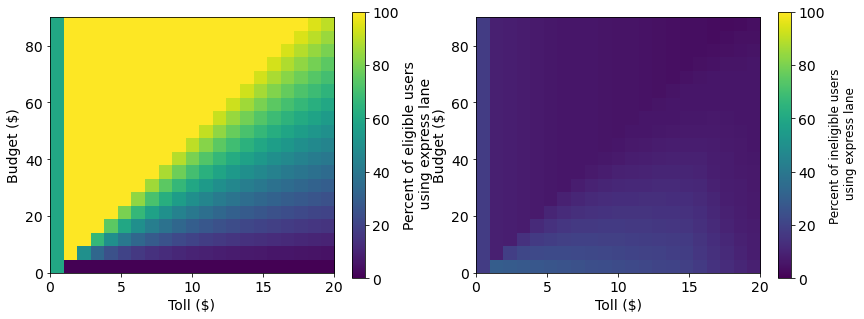

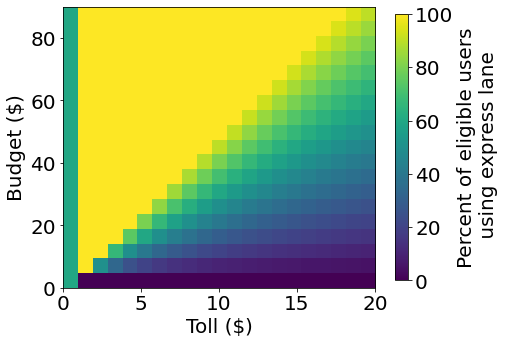

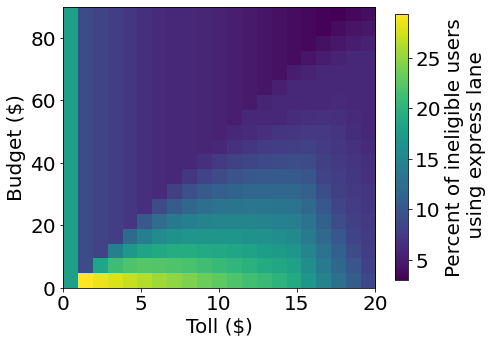

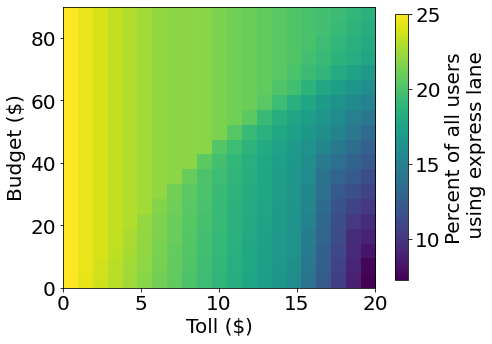

In [120]:
###### Fractions of users on the express lane ######
side_by_side_figs(x_plot,y_plot,[100*exp_el.T,100*exp_in.T],'Toll ($)','Budget ($)',
                  ["Percent of eligible users\n using express lane","Percent of ineligible users\n using express lane"],
                  'ExpressSharesELIN_2d',dimensions='2df',textSize=14)
side_by_side_figs(x_plot,y_plot,[100*exp_el.T],'Toll ($)','Budget ($)',
                  ["Percent of eligible users\n using express lane"],'ExpressSharesEL_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[100*exp_in.T],'Toll ($)','Budget ($)',
                  ["Percent of ineligible users\n using express lane"],'ExpressSharesIN_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[100*exp_all.T],'Toll ($)','Budget ($)',
                  ["Percent of all users\n using express lane"],'ExpressShareAll_2d',dimensions='2df',textSize=20)

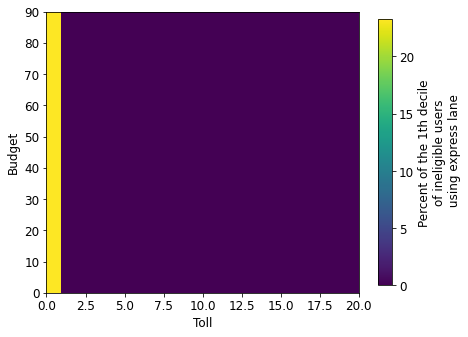

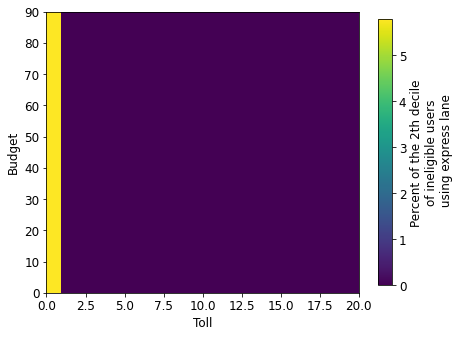

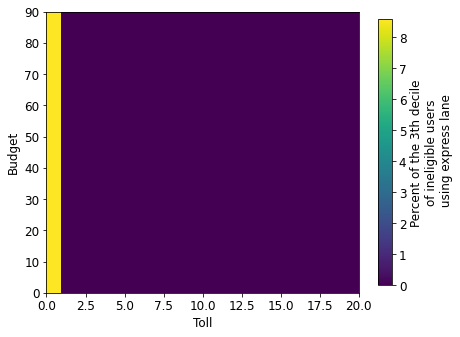

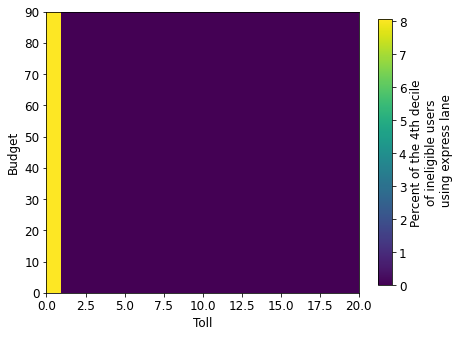

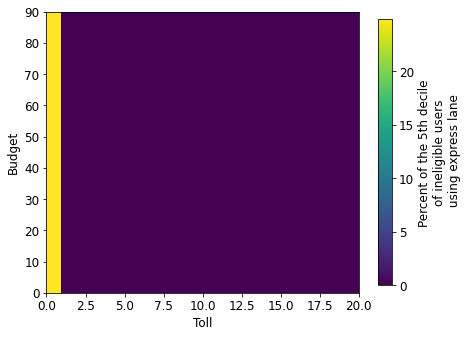

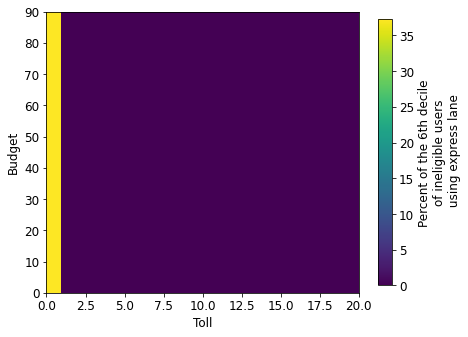

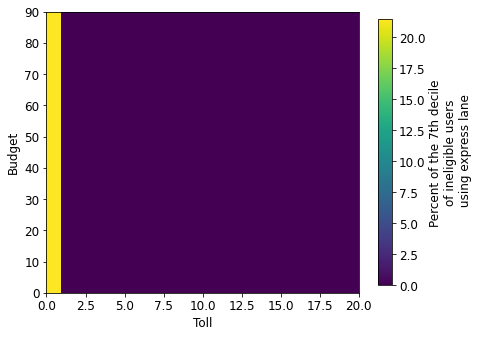

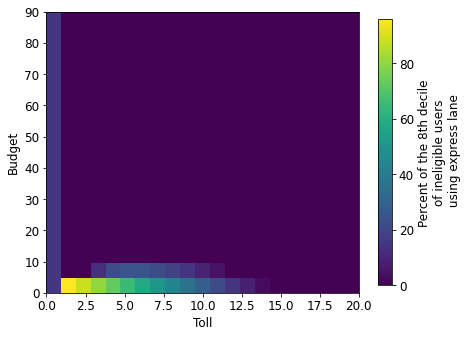

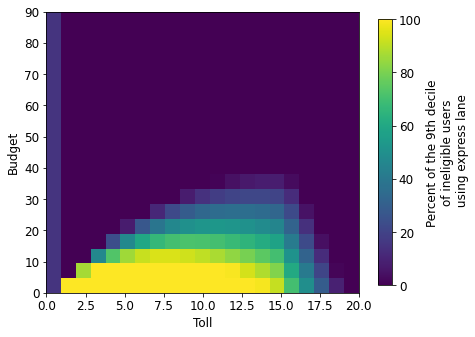

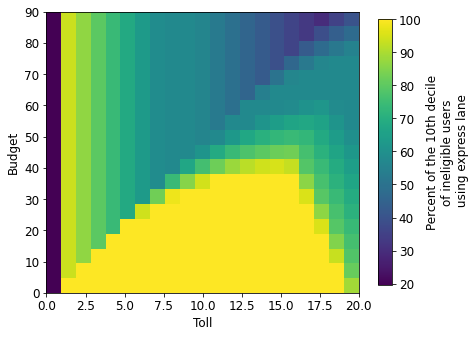

In [295]:
###### Fractions of ineligible users on the express lane by decile ######
for p in range(1,11):
    side_by_side_figs(x_plot,y_plot,[100*share_inel[10*p].T],'Toll','Budget',
                  ["Percent of the {}th decile\nof ineligible users\n using express lane".format(p)],'ExpressSharesINP{}_2d'.format(p),dimensions='2df')

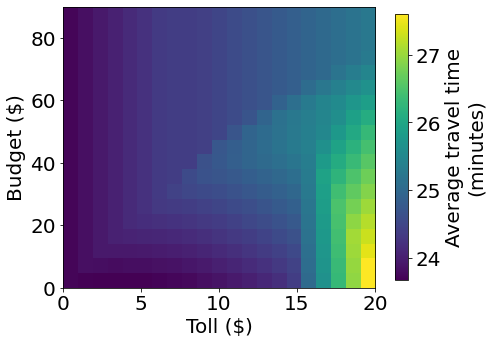

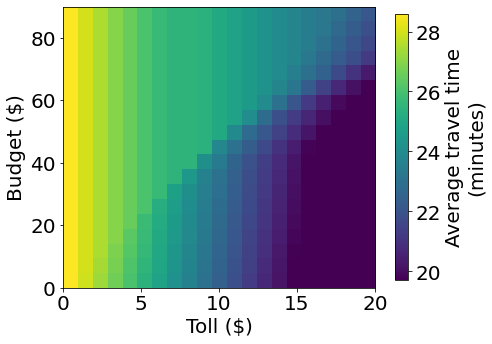

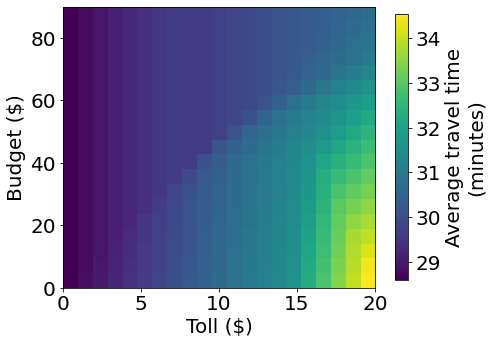

In [122]:
###### Average travel times ######
side_by_side_figs(x_plot,y_plot,[avg_tt.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'Avg_TravelTime_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[avg_EL_tt.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'AvgTravelTimesE_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[avg_GP_tt.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'AvgTravelTimesNE_2d',dimensions='2df',textSize=20)

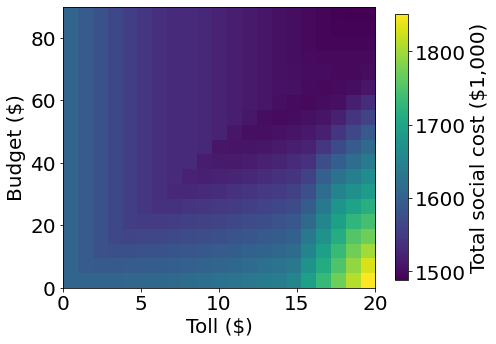

In [166]:
###### Pareto-weighted objective functions ######
weight_e = 35
weight_i = 1
weight_t = 1
z_labels={"1_0_0":"Total travel cost ($1,000)\nEligible users",
         "0_1_0":"Total travel cost ($1,000)\nIneligible users",
         "0_0_1":"Negative total toll revenue\n($1,000)",
         "1_1_1":"Total social cost ($1,000)",
         "5_1_1":"Total social cost ($1,000)",
          "10_1_1":"Total social cost ($1,000)",
         "11_1_1":"Total social cost ($1,000)",
         "12_1_1":"Total social cost ($1,000)",
         "15_1_1":"Total social cost ($1,000)","35_1_1":"Total social cost ($1,000)"}
side_by_side_figs(x_plot,y_plot,[((weight_i*total_tc_in.T)+(weight_e*total_tc_el.T)-(weight_t*total_tr.T))/1000],
                  'Toll ($)','Budget ($)',[z_labels["{}_{}_{}".format(weight_e,weight_i,weight_t)]],
                  'Total SWEL{}IN{}_TR{}_2d'.format(weight_e,weight_i,weight_t),dimensions='2df',textSize=20)

In [169]:
###### Compute optimal CBCP & metrics for various weigthing schemes ######
t_ix=0
b_ix=0
t=int(tau_arr[t_ix])
b=int(B_arr[b_ix])
weight_e = 1
weight_i = 1
weight_t = 1

this_df = []

for weight_e in range(21):
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in[i])+(weight_e*total_tc_el[i])-(weight_t*total_tr[i]))==np.min(
                        ((weight_i*total_tc_in)+(weight_e*total_tc_el)-(weight_t*total_tr))))[0]
        t=int(tau_arr[i])
        if len(this)>0:
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in[t_ix,b_ix]+total_tc_el[t_ix,b_ix]+total_tr[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt[t_ix,b_ix],1)
            this_df.append(this_row)
            
for s in [[1,0,0],[0,1,0],[0,0,1]]:
    weight_e = s[0]
    weight_i = s[1]
    weight_t = s[2]
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in[i])+(weight_e*total_tc_el[i])-(weight_t*total_tr[i]))==np.min(
                        ((weight_i*total_tc_in)+(weight_e*total_tc_el)-(weight_t*total_tr))))[0]
        t=int(tau_arr[i])
        if len(this)>0:
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in[t_ix,b_ix]+total_tc_el[t_ix,b_ix]+total_tr[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt[t_ix,b_ix],1)
            this_df.append(this_row)

this_df=pd.DataFrame.from_records(this_df)
this_df

,weight_e,weight_i,weight_t,toll,budget,ExpShare_All,ExpShare_El,ExpShare_In,TotalGenCost_All,TotalGenCost_El,TotalGenCost_In,TotalTR,AvgTT_Express,AvgTT_GP
0,0,1,1,13,0,17.0,0.0,21.0,989804.28,24260.83,876250.43,89293.01,20.7,31.2
1,1,1,1,13,0,17.0,0.0,21.0,989804.28,24260.83,876250.43,89293.01,20.7,31.2
2,2,1,1,12,0,18.0,0.0,21.0,981635.81,24113.31,872378.76,85143.73,21.3,31.0
3,3,1,1,12,0,18.0,0.0,21.0,981635.81,24113.31,872378.76,85143.73,21.3,31.0
4,4,1,1,12,0,18.0,0.0,21.0,981635.81,24113.31,872378.76,85143.73,21.3,31.0
5,5,1,1,11,0,18.0,0.0,22.0,973057.27,23964.31,868526.78,80566.18,21.9,30.8
6,6,1,1,11,0,18.0,0.0,22.0,973057.27,23964.31,868526.78,80566.18,21.9,30.8
7,7,1,1,11,0,18.0,0.0,22.0,973057.27,23964.31,868526.78,80566.18,21.9,30.8
8,8,1,1,10,0,19.0,0.0,23.0,964014.73,23815.11,864665.68,75533.94,22.4,30.6
9,9,1,1,10,0,19.0,0.0,23.0,964014.73,23815.11,864665.68,75533.94,22.4,30.6


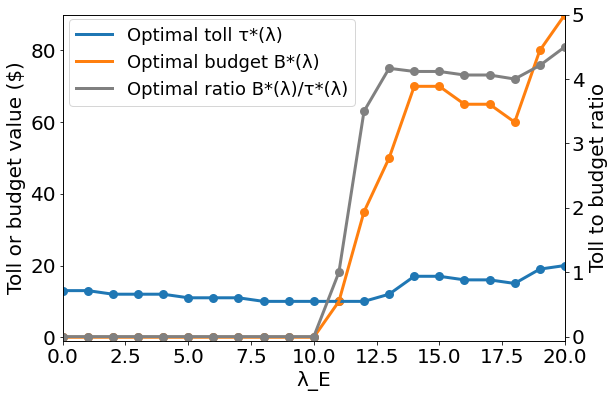

In [181]:
###### Plot optimal CBCP parameters with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3,label='Optimal toll τ*(λ)')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3,label='Optimal budget B*(λ)')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,label='Optimal ratio B*(λ)/τ*(λ)',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Toll or budget value ($)")
ax2.set_ylabel('Toll to budget ratio')
fig.legend(bbox_to_anchor=(0.09, 0.02, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 90))
ax2.set(xlim=(0,20), ylim=(-0.065, 5))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptTollBudget_weight_E.png',bbox_inches='tight')

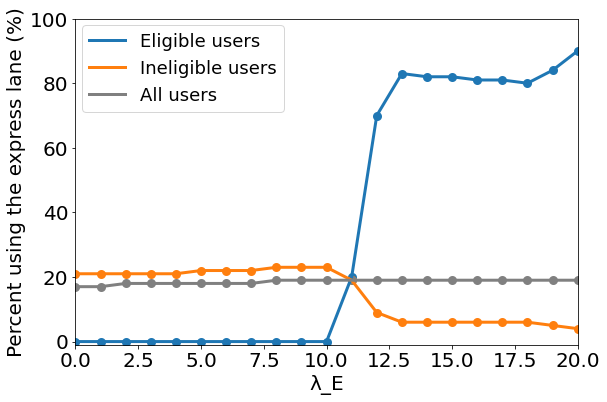

In [199]:
###### Plot optimal CBCP EL usage rates with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3,label='Eligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3,label='Ineligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,label='All users',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Percent using the express lane (%)")
fig.legend(bbox_to_anchor=(-0.04, 0.015, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 100))

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptUserShares_weight_E.png',bbox_inches='tight')

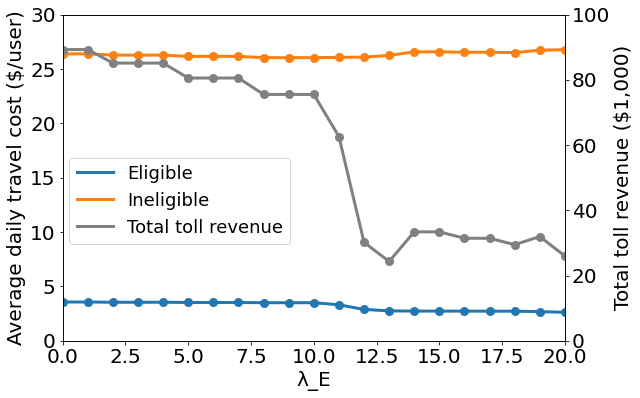

In [209]:
###### Plot optimal CBCP travel cost metrics with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(num_eligible*T),linewidth=3,label='Eligible')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3,label='Ineligible')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,label='Total toll revenue',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(T*num_eligible),linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average daily travel cost ($/user)")
ax2.set_ylabel('Total toll revenue ($1,000)')
fig.legend(bbox_to_anchor=(-0.01, -0.3, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(0, 30))
ax2.set(xlim=(0,20), ylim=(0, 100))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20) 
fig.savefig('OptSocialCosts_weight_E.png',bbox_inches='tight')

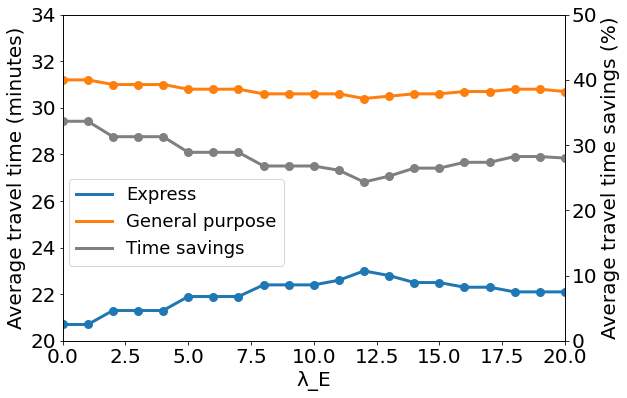

In [218]:
###### Plot optimal CBCP travel times with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3,label='Express')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3,label='General purpose')
ax2.plot(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,label='Time savings',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average travel time (minutes)")
ax2.set_ylabel('Average travel time savings (%)')
fig.legend(bbox_to_anchor=(-0.02, -0.35, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(20, 34))
ax2.set(xlim=(0,20), ylim=(0, 50))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptTravelTimes_weight_E.png',bbox_inches='tight')